# ZAP Data Challenge


## O problema
- Desafio
- Os dados
- Carregar os dados
- Análise rápida dos dados de Treino
- Análise rápida dos dados de Teste

## EDA Identificar Variáveis
- Quais os tipos de variáveis
- Estatísticas das variáveis idependentes e a dependente
- Tendencias e distribuições

## Relações entre as variáveis
- Plotar Correlações numéricas
- Plotar relações da váriavel dependente com as categorias

## Limpeza de Dados
- Avaliar contradições e duplicados
- Avaliando Missing Values em variáveis numéricas
- Avaliando Missing em variáveis categóricas
- Remoção, Imputação com missings

## Outiliers
- Remoção, natural log, binning, pesos

## Transformação 
- logaritima, square, raiz cúbica, binning, discretization, fatorização...

## Feature Engineering
- Agrupar 
- Amplitude
- Adição, multiplicação, divisão de features
- Extração de domínio e tempo
- Métodos de importancia de variáveis
- Hashing com geolocalização

## Feature Selection
- Filter métodos
- Wrapper métodos
- ou Embedded métodos

## Modelar e testar
- Random Forest
- XGBoost
- LightGBM


In [1]:
import json 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zaputils as zap
import pygeohash as gh
import statsmodels.api as sm
from sklearn.svm import SVR
import xgboost as xgb
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce
# sklearn pipeline to put it all together
from sklearn.pipeline import Pipeline as pipe
from lightgbm import LGBMRegressor
from pandas.io.json import json_normalize
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer 
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
#from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.metrics import mean_absolute_error,mean_squared_error, make_scorer, r2_score

import warnings
warnings.filterwarnings('ignore')
#formtando como pandas mostra números
pd.options.display.float_format = '{:,.6f}'.format
sns.set(palette='muted')
pd.set_option('max_columns', None)
%load_ext autoreload
%autoreload 2

## O problema
O Zap disponibiliza uma base de dados e nosso objetivo é achar o preço de *VENDA* do apartamento. 
Seu trabalho é criar uma maneira automática de estimar um preço de venda para os apartamentos no dataset de *TESTE*.
- Ou seja somente nos iteressa anúncios de *venda*
- Vamos trabalhar para previsão somente nesta base de *TESTE*
- Como não foi especificado que o modelo será reutilizado nosso objetivo é obter a menor margem de _erro_ no preço de *venda*.
- O meu tempo é muito curto, no meu caso, 1 dia então vou me conter ao básico
- Para economizar espaço vou retirar no começo algumas variáveis que já analisei anteriormente*
### Os dados

<div style="float:left">
<table>
<tr><td>usableAreas:</td><td> tamanho do imóvel em m²</td></tr>
<tr><td>description:</td><td> descrição do anúncio</td></tr>
<tr><td>title:</td><td> título do anúncio</td></tr>
<tr><td>createdAt:</td><td> timestamp da criação do anúncio</td></tr>
<tr><td>publisherId:</td><td> identificador do anunciante</td></tr>
<tr><td>unitTypes:</td><td> tipo do imóvel (apartamento, casa, comércial, etc)</td></tr>
<tr><td>listingStatus:</td><td> status do anúncio (ativo ou inativo)</td></tr>
<tr><td>id:</td><td> identificador único do anúncio</td></tr>
<tr><td>parkingSpaces:</td><td> número de vagas de garagem</td></tr>
<tr><td>updatedAt:</td><td> timestamp do último update</td></tr>
<tr><td>owner:</td><td> indicador se o anunciante é proprietário do imóvel</td></tr>
<tr><td>images:</td><td> lista de links de imagens do anúncio</td></tr>
<tr><td>address:</td><td> endereço do imóvel</td></tr>
<tr><td>country:</td><td> país do imóvel</td></tr>
<tr><td>zipCode:</td><td> CEP do imóvel</td></tr>
<tr><td>city:</td><td> cidade do imóvel</td></tr>
<tr><td>streetNumber:</td><td> número da rua</td></tr>
<tr><td>zone:</td><td> zona do imóvel</td></tr>
</table>
</div>
<div style="float:left">
<table>
<tr><td>geoLocation:</td><td> geolocalização do imóvel</td></tr>
<tr><td>street:</td><td> nome da rua</td></tr>
<tr><td>locationId:</td><td> id da localização</td></tr>
<tr><td>district:</td><td> distrito do imóvel</td></tr>
<tr><td>unitNumber:</td><td> complemento do imóvel</td></tr>
<tr><td>state:</td><td> estado federativo do imóvel</td></tr>
<tr><td>neighborhood:</td><td> bairro do imóvel</td></tr>
<tr><td>publicationType:</td><td> tipo de publicação do anúncio (normal ou premium)</td></tr>
<tr><td>bathrooms:</td><td> número de banheiros</td></tr>
<tr><td>totalAreas:</td><td> área total do imóvel em m²</td></tr>
<tr><td>bedrooms:</td><td> número de quartos</td></tr>
<tr><td>suites:</td><td> número de suites</td></tr>
<tr><td>princingInfos:</td><td> informações do preço</td></tr>
<tr><td>price:</td><td> preço de venda</td></tr>
<tr><td>yearlyIptu:</td><td> preço do IPTU</td></tr>
<tr><td>businessType:</td><td> tipo do anúncio (venda, aluguel ou ambos)</td></tr>
<tr><td>monthlyCondoFee:</td><td> condomínio</td></tr>
<tr><td>rentalTotalPrice:</td><td> preço do aluguel</td></tr>
</table>
</div>
<div style="clear: both;"></div>

### Observações
- São apresentados no formato json e tem sub datasets portanto devem ser normalizados
- Foi criado um arquivo helper, para manter o notebook mais limpo vou colocar as funções criadas nele, para analise do código favor consultar o zaputils.py
- Vou descartar os links de imagens, nesse momento não daria tempo modelar as imagens


In [2]:
#carregando dados de treino e teste e removendo algumas colunas inúteis analisadas anteriormente
train = zap.readAndFlatDataSet('source-4-ds-train.json')
train = train.loc[:,['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision','address.neighborhood', 'address.zipCode',
       'bathrooms', 'bedrooms','owner', 'parkingSpaces','address.street',
       'pricingInfos.businessType', 'pricingInfos.monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.rentalTotalPrice', 'pricingInfos.yearlyIptu',
       'publicationType', 'publisherId', 'suites','totalAreas',
       'unitTypes', 'usableAreas','pricingInfos.price']].copy()
train = train.rename(columns ={'pricingInfos.price':'price', 
                               'pricingInfos.monthlyCondoFee':'monthlyCondoFee',
                               'pricingInfos.yearlyIptu':'yearlyIptu'
                              })
test = zap.readAndFlatDataSet('source-4-ds-test.json')
test = test.loc[:,['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision','address.neighborhood', 'address.zipCode',
       'bathrooms', 'bedrooms','owner','parkingSpaces','address.street',
       'pricingInfos.businessType', 'pricingInfos.monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.rentalTotalPrice', 'pricingInfos.yearlyIptu',
       'publicationType', 'publisherId', 'suites','totalAreas',
       'unitTypes', 'usableAreas','pricingInfos.price']]
test = test.rename(columns ={'pricingInfos.price':'price', 
                             'pricingInfos.monthlyCondoFee':'monthlyCondoFee',
                             'pricingInfos.yearlyIptu':'yearlyIptu'
                              })

In [3]:
train.head(2)

,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.neighborhood,address.zipCode,bathrooms,bedrooms,owner,parkingSpaces,address.street,pricingInfos.businessType,monthlyCondoFee,pricingInfos.period,pricingInfos.rentalTotalPrice,yearlyIptu,publicationType,publisherId,suites,totalAreas,unitTypes,usableAreas,price
0,-23.612923,-46.614222,ROOFTOP,Jardim da Saúde,04290030,3.000000,4.000000,False,6.000000,Rua Juvenal Galeno,SALE,nan,NaN,nan,nan,STANDARD,f4603b2b52,1.000000,388.000000,TWO_STORY_HOUSE,388.000000,700000
1,-23.643962,-46.593475,RANGE_INTERPOLATED,Vila Santa Teresa (Zona Sul),04187320,2.000000,3.000000,False,2.000000,Rua Juruaba,SALE,nan,NaN,nan,nan,STANDARD,f4603b2b52,1.000000,129.000000,HOME,129.000000,336000


In [4]:
test.head(2)

,address.geoLocation.location.lat,address.geoLocation.location.lon,address.geoLocation.precision,address.neighborhood,address.zipCode,bathrooms,bedrooms,owner,parkingSpaces,address.street,pricingInfos.businessType,monthlyCondoFee,pricingInfos.period,pricingInfos.rentalTotalPrice,yearlyIptu,publicationType,publisherId,suites,totalAreas,unitTypes,usableAreas,price
0,-23.557225,-46.662765,GEOMETRIC_CENTER,Consolação,01415000,1.000000,1,False,1.000000,Rua Bela Cintra,SALE,nan,NaN,nan,nan,STANDARD,967d57ce20,0.000000,47.000000,APARTMENT,47.000000,None
1,-23.592852,-46.581879,ROOFTOP,Quinta da Paineira,03152155,0.000000,2,False,1.000000,Rua Bruno Cavalcanti Feder,SALE,0.000000,NaN,nan,0.000000,STANDARD,bddebf057a,0.000000,55.000000,APARTMENT,55.000000,None


In [5]:
# Análise rápida dados de treino
zap.getSomeStats(train, 'price')

Data shape: (133964, 22)
ooooooooooooooooooooooooooo
Data types:
 float64    11
object      9
bool        1
int64       1
Name: types, dtype: int64
ooooooooooooooooooooooooooo


,types,counts,distincts,nulls,null_ratio,uniques,skewness,kurtosis,corr price
address.geoLocation.location.lat,float64,133953,43492,11,0.008000,"[[-23.612923, -23.643962, -23.568559, -23.5980...",129.964314,"18,533.095737",-0.017469
address.geoLocation.location.lon,float64,133953,45040,11,0.008000,"[[-46.614222, -46.593475, -46.647452, -46.6827...",140.698116,"20,602.339939",-0.014008
address.geoLocation.precision,object,133953,6,11,0.008000,"[[ROOFTOP, RANGE_INTERPOLATED, GEOMETRIC_CENTE...",nan,nan,nan
address.neighborhood,object,133964,1634,0,0.000000,"[[Jardim da Saúde, Vila Santa Teresa (Zona Sul...",nan,nan,nan
address.zipCode,object,133964,15925,0,0.000000,"[[04290030, 04187320, 01311000, 04550004, 0400...",nan,nan,nan
bathrooms,float64,133051,57,913,0.682000,"[[3.0, 2.0, 4.0, 5.0, 0.0, 1.0, 6.0, 10.0, 7.0...",15.134062,846.668032,0.245185
bedrooms,float64,130945,31,3019,2.254000,"[[4.0, 3.0, 0.0, 1.0, 2.0, 5.0, nan, 7.0, 6.0,...",168.117886,"46,523.355712",0.132376
owner,bool,133964,2,0,0.000000,"[[False, True]]",59.350211,"3,520.500145",-0.003220
parkingSpaces,float64,129539,120,4425,3.303000,"[[6.0, 2.0, 5.0, 1.0, 20.0, 3.0, 4.0, 0.0, 25....",34.226712,"2,283.997481",0.135957
address.street,object,133964,12933,0,0.000000,"[[Rua Juvenal Galeno, Rua Juruaba, Avenida Pau...",nan,nan,nan


In [6]:
train.describe(include=[np.object,np.bool]).T

,count,unique,top,freq
address.geoLocation.precision,133953,5,ROOFTOP,75073
address.neighborhood,133964,1634,Jardim Paulista,4284
address.zipCode,133964,15925,,5908
owner,133964,2,False,133926
address.street,133964,12933,,7002
pricingInfos.businessType,133964,2,SALE,105332
pricingInfos.period,29051,3,MONTHLY,29029
publicationType,133964,2,STANDARD,131595
publisherId,133964,3533,d7190e8f4c,3625
unitTypes,133964,19,APARTMENT,72241


In [7]:
train.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
address.geoLocation.location.lat,"133,953.000000",-23.554263,0.165147,-23.848153,-23.594475,-23.558990,-23.527634,0.000000
address.geoLocation.location.lon,"133,953.000000",-46.643395,0.318494,-46.820973,-46.684151,-46.654071,-46.607885,0.000000
bathrooms,"133,051.000000",2.375683,2.146044,0.000000,1.000000,2.000000,3.000000,200.000000
bedrooms,"130,945.000000",2.327023,2.140123,0.000000,2.000000,2.000000,3.000000,600.000000
parkingSpaces,"129,539.000000",2.443187,5.251624,0.000000,1.000000,2.000000,3.000000,589.000000
monthlyCondoFee,"117,127.000000","1,507.678520","77,954.055478",0.000000,0.000000,399.000000,861.000000,"24,430,000.000000"
pricingInfos.rentalTotalPrice,"28,714.000000","11,021.829874","77,012.229803",0.000000,"2,310.000000","4,111.500000","9,100.000000","11,900,000.000000"
yearlyIptu,"114,612.000000","4,182.520076","850,109.115348",0.000000,0.000000,84.000000,364.000000,"283,024,210.000000"
suites,"120,347.000000",1.106534,1.218938,0.000000,0.000000,1.000000,2.000000,80.000000
totalAreas,"91,132.000000","13,270.587445","3,682,657.704270",0.000000,60.000000,120.000000,250.000000,"1,111,111,111.000000"


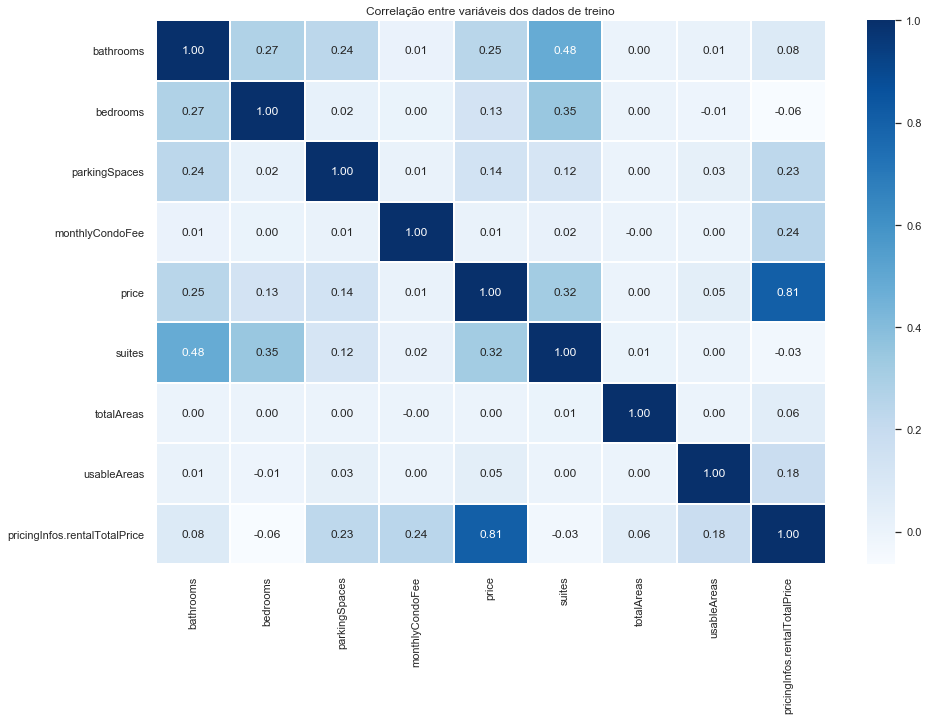

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[['bathrooms', 'bedrooms', 'parkingSpaces',
       'monthlyCondoFee','price',
       'suites', 'totalAreas','usableAreas','pricingInfos.rentalTotalPrice']].corr(),
            annot = True,
            linewidths=True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis dos dados de treino')
plt.show()

## Analise dos dados de Treino
- De cara vemos que as variáveis numéricas possuem outliers, a assimetria com caudas logas a direita,  e a curtose é enorme em alguma delas inclusive na dependente, vamos ter que normalizar os dados
- *As correlações não são altas, apenas na variável preço de aluguel,me parece obvio que o coeficiente e o slope da equação teriam um R2 altissimo, obviamente foram removidos para aumentar o desafio* **quem sabe rodar uma regressão e achar os coeficientes do preço de aluguel com quartos, suites, geolocalização ou neighborhood e outros numéricos? podemos ter uma previsão muito mais alta do preço
- As datas tb serão removidas não vou ter tempo para analisar
- Endereços, ceps e zondas podem ser substituidos por um geohashing
- Neighborhood não tem nulos quem sabe um feature hashing,  top target encoding, ou até mesmo mean encoding de qq forma temos que rodar tudo em um pipeline para evitar leakage.
- Total areas contém muitos nulos tambêm e pelo que notei não há uma maneira de calcula-lo automáticamente com os dados que temos, um candidato a remoção
- City, country e district, listingstatus não contem nada relevante
- Vou precisar de street para preenchimento de latitudes missings
- id, title, description irei remover provavelmente é claro que as descrições podem ter muito valor, mas no momento quero uma solução simples
- Unittypes e zonas não contem cardinalidade grande podemos categorizar com One Hot, note que zones possui o top em branco...
- Preço primeiro quartil 170k e mínimo 70 reais? Vejam os outiliers ai minha gente!
- MonthlyCondoFee com o terceiro quartil 700 e Max de 24 milhões? temos que ver isso
- 4284 Apartamentos no jardim paulista!
- Um standardscaler ou minmax não vão dar conta de tantos outliers considero já para variáveis numéricas uma normalização boxcox ou robustscaler ou normalizar não mão com IQR x 1.5 ou 3 e depois usar um scaler.


In [9]:
#analise rápida dados de teste
zap.getSomeStats(test)

Data shape: (16036, 22)
ooooooooooooooooooooooooooo
Data types:
 object     10
float64    10
bool        1
int64       1
Name: types, dtype: int64
ooooooooooooooooooooooooooo


,types,counts,distincts,nulls,null ratio,uniques,skewness,kurtosis
address.geoLocation.location.lat,float64,16033,8899,3,0.019000,"[[-23.557225, -23.592852, -23.493609, -23.6079...",85.216399,"7,503.512090"
address.geoLocation.location.lon,float64,16033,8923,3,0.019000,"[[-46.662765, -46.581879, -46.638456, -46.6861...",87.725079,"7,799.608427"
address.geoLocation.precision,object,16033,6,3,0.019000,"[[GEOMETRIC_CENTER, ROOFTOP, APPROXIMATE, RANG...",nan,nan
address.neighborhood,object,16036,801,0,0.000000,"[[Consolação, Quinta da Paineira, Chora Menino...",nan,nan
address.street,object,16036,3059,0,0.000000,"[[Rua Bela Cintra, Rua Bruno Cavalcanti Feder,...",nan,nan
address.zipCode,object,16036,4231,0,0.000000,"[[01415000, 03152155, 02461000, 04561003, 0546...",nan,nan
bathrooms,float64,16035,14,1,0.006000,"[[1.0, 0.0, 3.0, 4.0, 2.0, 5.0, 6.0, 7.0, 8.0,...",13.898425,726.517702
bedrooms,int64,16036,12,0,0.000000,"[[1, 2, 3, 4, 0, 5, 6, 30, 8, 31, 7, 54]]",12.007201,561.235845
monthlyCondoFee,float64,15100,1417,936,5.837000,"[[nan, 0.0, 686.0, 770.0, 472.0, 350.0, 251.0,...",66.234864,"4,857.236336"
owner,bool,16036,2,0,0.000000,"[[False, True]]",73.098106,"5,341.999376"


In [10]:
test.describe(include=[np.object,np.bool]).T

,count,unique,top,freq
address.geoLocation.precision,16033,5,ROOFTOP,9108
address.neighborhood,16036,801,Higienópolis,432
address.zipCode,16036,4231,,638
owner,16036,2,False,16033
address.street,16036,3059,,720
pricingInfos.businessType,16036,1,SALE,16036
pricingInfos.period,75,1,MONTHLY,75
publicationType,16036,2,STANDARD,15767
publisherId,16036,1817,a8b38b03a8,430
unitTypes,16036,1,APARTMENT,16036


In [11]:
test_desc = test.describe(include=np.number, percentiles=[.05,.15,.90,.99],).T
train_desc = train.describe(include=np.number, percentiles=[.05,.15,.90,.99],).T

In [12]:
pdquants = pd.concat([test_desc.loc[:,['5%','15%','90%','99%']],train_desc.loc[:,['5%','15%','90%','99%']]],
           axis=1, ignore_index=True, sort=False)
pdquants.columns =['test5%','test15%','test90%','test99%','5%','15%','90%','99%']
display(pdquants)
del pdquants, test_desc, train_desc

,test5%,test15%,test90%,test99%,5%,15%,90%,99%
address.geoLocation.location.lat,-23.626480,-23.612108,-23.486084,-23.460334,-23.623017,-23.607555,-23.480999,-23.453438
address.geoLocation.location.lon,-46.747112,-46.708793,-46.568656,-46.472994,-46.744325,-46.706369,-46.563884,-46.461097
bathrooms,1.000000,1.000000,4.000000,6.000000,0.000000,1.000000,5.000000,8.000000
bedrooms,1.000000,2.000000,4.000000,4.000000,0.000000,1.000000,4.000000,5.000000
parkingSpaces,1.000000,1.000000,3.000000,5.000000,0.000000,1.000000,4.000000,14.000000
monthlyCondoFee,0.000000,175.000000,"1,575.000000","4,130.350000",0.000000,0.000000,"1,750.000000","5,950.000000"
pricingInfos.rentalTotalPrice,0.000000,0.000000,0.000000,"2,235.030000","1,330.000000","1,959.000000","19,674.200000","115,620.800000"
yearlyIptu,0.000000,0.000000,840.000000,"6,300.000000",0.000000,0.000000,"1,134.000000","10,500.000000"
suites,0.000000,0.000000,3.000000,4.000000,0.000000,0.000000,3.000000,4.000000
totalAreas,0.000000,49.000000,290.000000,"1,500.000000",0.000000,45.000000,500.000000,"2,821.000000"


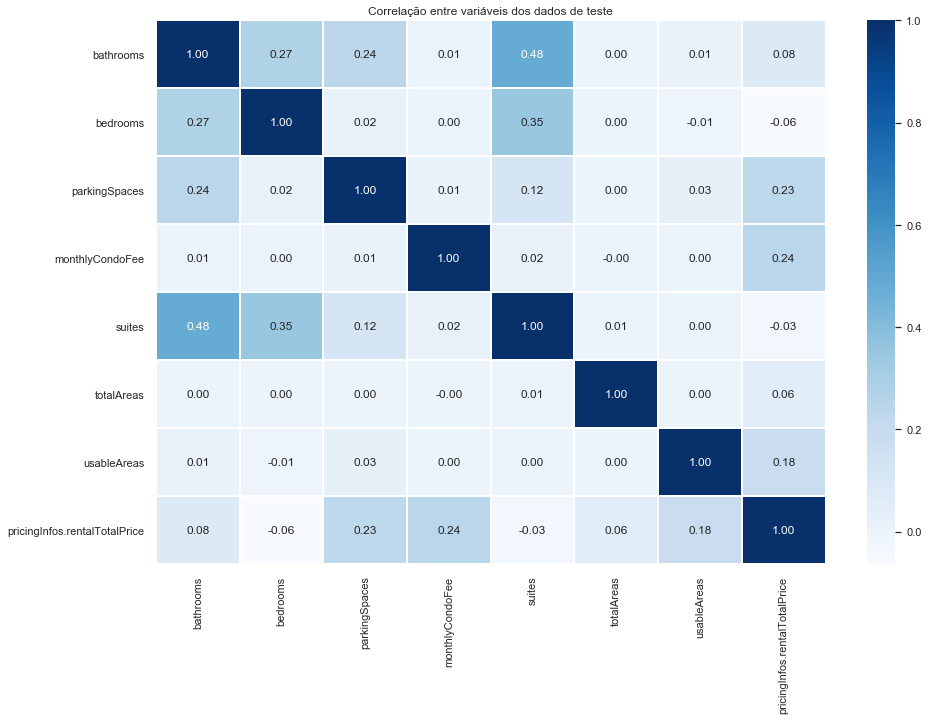

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(train[['bathrooms', 'bedrooms', 'parkingSpaces',
       'monthlyCondoFee',
       'suites', 'totalAreas','usableAreas','pricingInfos.rentalTotalPrice']].corr(),
            annot = True,
            linewidths=True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis dos dados de teste')
plt.show()

### Breve analise de Teste
- UnitTypes somente apartamento
- BusinessTypes somente SALES
- pricingInfos.period	somente MONTHLY
- 432 ap's em higienópolis!


### Explorando e eliminando Missing Values
#### Mecanismo dos Missing values
Para entendermos completamente a importância da falta de dados, precisamos identificar de forma abrangente os motivos da ocorrência de dados ausentes. O primeiro passo é entender seus dados e, mais importante, o processo de coleta de dados. Isso pode levar à possibilidade de reduzir erros na coleta de dados. A natureza ou mecanismo de dados perdidos pode ser categorizado em três classes. Essas categorias são baseadas no grau de relação entre a natureza dos dados ausentes e os valores observados.

1) Missing Completely at Random (MCAR): 
- Significa que a natureza dos dados perdidos não está relacionada a nenhuma das variáveis, seja nos missings ou presentes. Nesse caso, o missingness na variável é completamente não sistemático. Por exemplo, vamos analisar um estudo que envolve determinar o motivo da obesidade entre crianças. O MCAR é quando os pais se esquecem de levar os filhos para a clínica.

2) Missing at Random (MAR):
- Significa que a natureza dos dados ausentes está relacionada aos dados observados, mas não aos dados ausentes. Usando o estudo acima, a falta de dados neste caso deve-se ao fato de os pais terem se mudado para uma cidade diferente e, portanto, as crianças tiveram que deixar o estudo - a falta de nada tem a ver com o estudo

3) Missing Not at Random (MNAR): 
- É conhecido como não-ignorável porque o mecanismo de missing não pode ser ignorado. Eles existem quando os valores ausentes não são nem MCAR nem MAR. Os valores em falta na variável estão relacionados com as variáveis observadas e não observadas. Um exemplo de MNAR é que os pais são ofendidos pela natureza do estudo e não querem que seus filhos sejam vítimas de bullying, então eles retiraram as crianças do estudo. A dificuldade com os dados do MNAR está intrinsecamente associada à questão da identificabilidade.

Perceba como o pacote missingno pode ajudar a detectar padrões nos dados

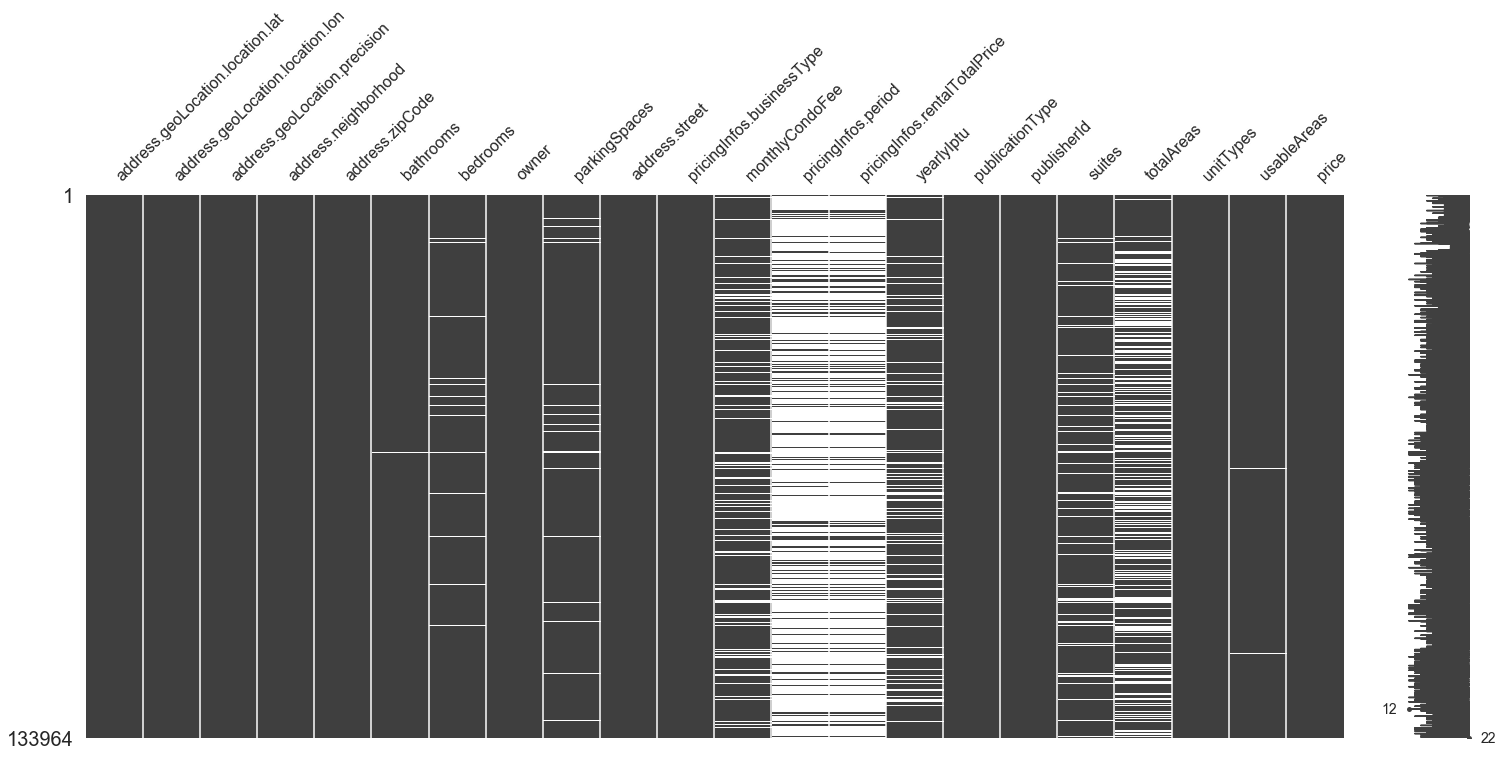

In [14]:
import missingno as msno
missingdata_df = list(train.isnull().columns)
msno.matrix(train[missingdata_df])

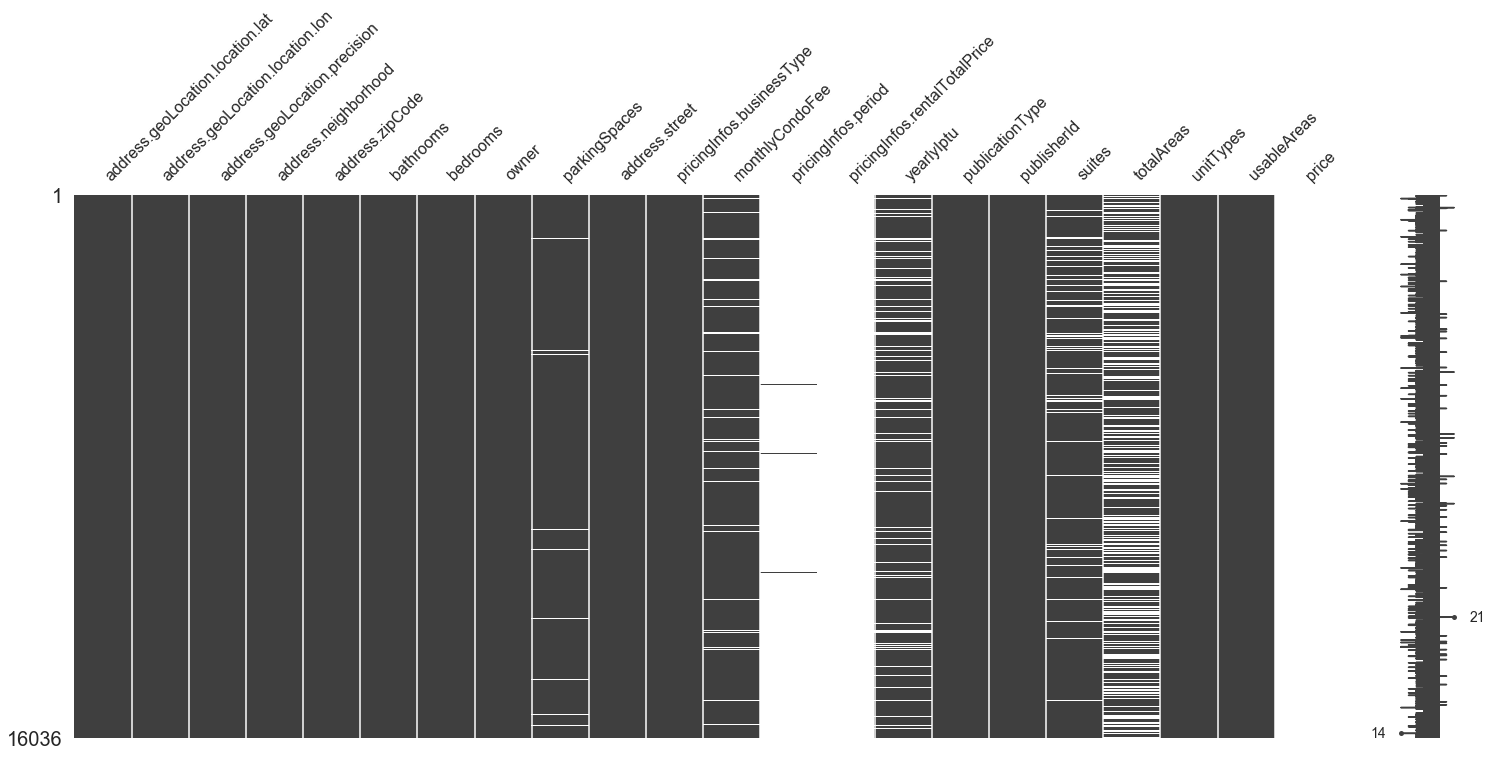

In [15]:
# Em Teste
test_missingdata_df = list(test.isnull().columns)
msno.matrix(test[test_missingdata_df])

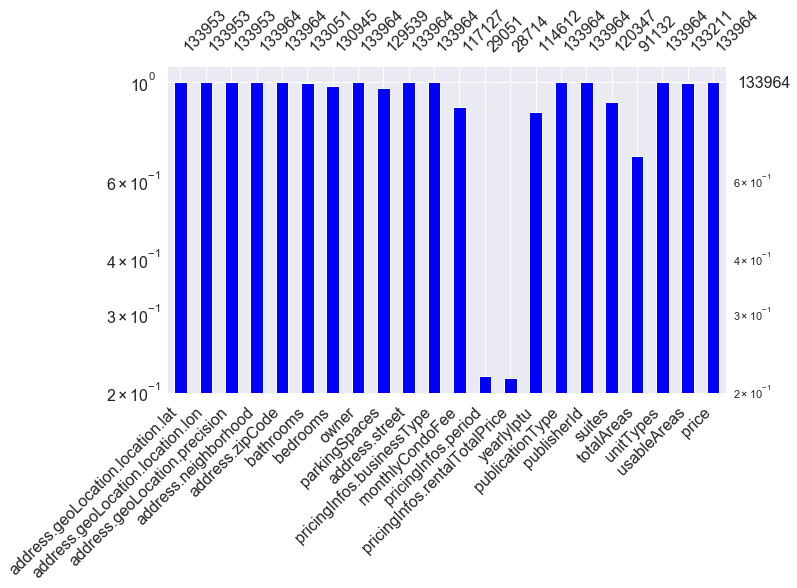

In [16]:
msno.bar(train[missingdata_df], color="blue", log=True, figsize=(10,6))

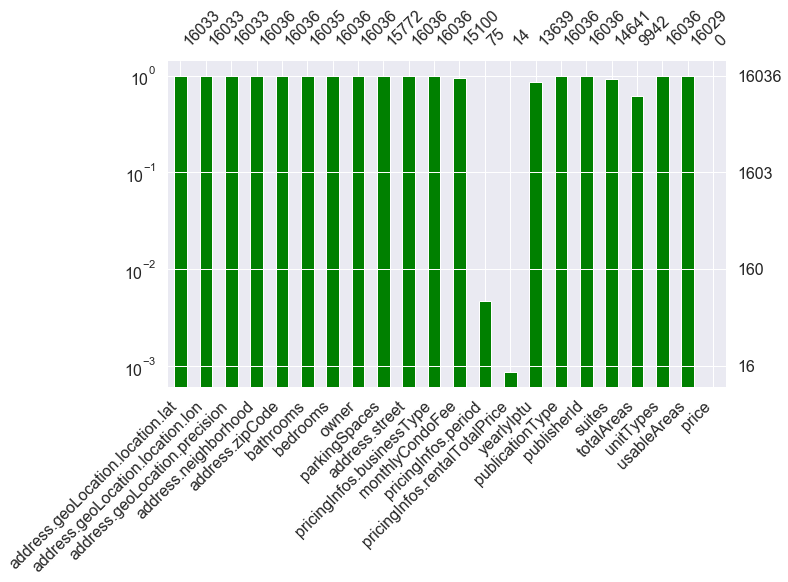

In [17]:
# teste
msno.bar(test[test_missingdata_df], color="green", log=True, figsize=(10,6))

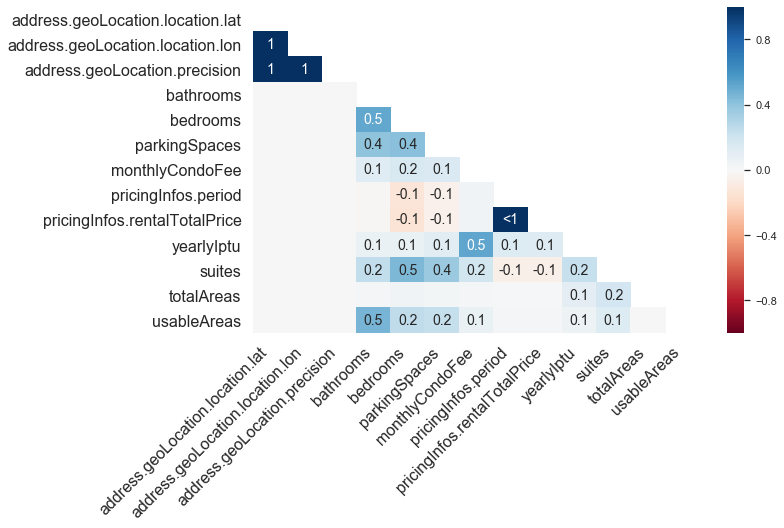

In [18]:
msno.heatmap(train[missingdata_df], figsize=(10,6))

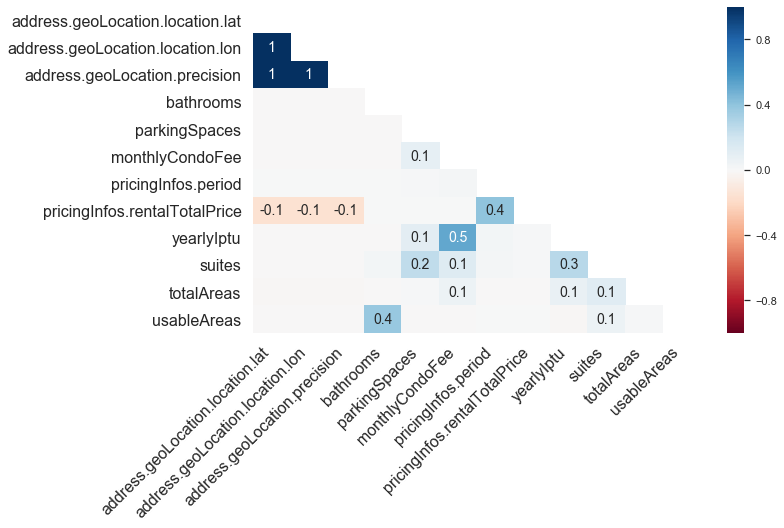

In [19]:
test_miss = [var for var in missingdata_df if var != 'price']
msno.heatmap(test[test_miss], figsize=(10,6))

###### Acima  vemos uma grande correlação de missings de banheiros e quartos, garagens, suites e area usável, ou seja se exibissimos um grafico desses missings veriamos em um scatter uma relação bem positiva principalmente a 0.7
Tenho que decidir logo o que fazer com esses dados:
*Vamos ver os métodos usuais usados para lidar com missings*
- Complete Case Analysis
- Random sample imputation
- Adicionar uma variável para capturar NA
- End of distribution Imputation
- Arbitrary value Imputation
- Frequent Categoy Imputation
- -999 depois tirar a média de uma categórica em uma nova coluna
- Devido ao pouco tempo que tenho decidi que usarei MICE imputation para quartos, suites e algumas outras variáveis

## Ponto Importante
A Engenharia de features que exige métricas deve ser feita na fase de Treino e propagada de treino para Teste, dessa maneira evitamos overfiting e leakage

### Imputando geolocations
* Como vou deletar zipcode e street, construi uma função que recupera a rua e imputa a moda daquela rua nas geolocations nulas, se a rua é nula imputa com base no bairro

In [20]:
#imputando geolocations 
train_imp = train.copy()
zap.fillGeolocationWithStreetMode(train_imp)
train_imp['address.geoLocation.location.lat'].isnull().sum()

0

In [21]:
test_imp = test.copy()
zap.fillGeolocationWithStreetMode(test_imp)
test_imp['address.geoLocation.location.lat'].isnull().sum()

0

### Vamos converter a geolocalização com geohash que permite criar categorias com as latitudes e longitude
- Taxa de precisão
<br>1	≤ 5,000km	×	5,000km
<br>2	≤ 1,250km	×	625km
<br>3	≤ 156km	×	156km
<br>4	≤ 39.1km	×	19.5km
<br>5	≤ 4.89km	×	4.89km
<br>6	≤ 1.22km	×	0.61km
<br>7	≤ 153m	×	153m
<br>8	≤ 38.2m	×	19.1m
<br>9	≤ 4.77m	×	4.77m
<br>10	≤ 1.19m	×	0.596m
<br>11	≤ 149mm	×	149mm
<br>12	≤ 37.2mm	×	18.6mm

*Vou criar duas categorias geohash com área de 4.98km e geohash_high com precisão de 1.22 kilometros


In [22]:
def applyGeoHash(ds):
    ds['geohash']=ds.apply(lambda x: gh.encode(x['address.geoLocation.location.lat'], 
                                               x['address.geoLocation.location.lon'], precision=5), axis=1)
    ds['geohash_high']=ds.apply(lambda x: gh.encode(x['address.geoLocation.location.lat'], 
                                               x['address.geoLocation.location.lon'], precision=6), axis=1)

In [23]:
applyGeoHash(train_imp)
display(train_imp[['geohash','geohash_high']].head(3))
display(train_imp.geohash.nunique())
display(train_imp.geohash_high.nunique())

,geohash,geohash_high
0,6gyce,6gycem
1,6gyc7,6gyc7x
2,6gycf,6gycft


68

1271

In [24]:
applyGeoHash(test_imp)
display(test_imp[['geohash','geohash_high']].head(3))
display(test_imp.geohash.nunique())
display(test_imp.geohash_high.nunique())

,geohash,geohash_high
0,6gycf,6gycfp
1,6gycu,6gycu1
2,6gyf6,6gyf6e


58

855

In [25]:
#categorizar geocode
train_imp.geohash = train_imp.geohash.astype('category')
train_imp.geohash_high = train_imp.geohash_high.astype('category')
train_imp.owner = train_imp.owner.astype('category')

train_imp.publicationType = train_imp.publicationType.astype('category')
train_imp.publisherId = train_imp.publisherId.astype('category')
train_imp['address.neighborhood'] = train_imp['address.neighborhood'].astype('category')
test_imp.geohash = test_imp.geohash.astype('category')
test_imp.geohash_high = test_imp.geohash_high.astype('category')
test_imp.owner = test_imp.owner.astype('category')

test_imp.publicationType = test_imp.publicationType.astype('category')
test_imp.publisherId = test_imp.publisherId.astype('category')
test_imp['address.neighborhood'] = test_imp['address.neighborhood'].astype('category')



In [26]:
import pprint as p
p.pprint(train_imp.columns)
p.pprint(test_imp.columns)
p.pprint(train_imp.shape)
p.pprint(test_imp.shape)

Index(['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision', 'address.neighborhood',
       'address.zipCode', 'bathrooms', 'bedrooms', 'owner', 'parkingSpaces',
       'address.street', 'pricingInfos.businessType', 'monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.rentalTotalPrice', 'yearlyIptu',
       'publicationType', 'publisherId', 'suites', 'totalAreas', 'unitTypes',
       'usableAreas', 'price', 'geohash', 'geohash_high'],
      dtype='object')
Index(['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision', 'address.neighborhood',
       'address.zipCode', 'bathrooms', 'bedrooms', 'owner', 'parkingSpaces',
       'address.street', 'pricingInfos.businessType', 'monthlyCondoFee',
       'pricingInfos.period', 'pricingInfos.rentalTotalPrice', 'yearlyIptu',
       'publicationType', 'publisherId', 'suites', 'totalAreas', 'unitTypes',
       'usableAreas', '

### Agora podemos remover algumas variáveis

1

,count,mean,std,min,25%,50%,75%,max
address.geoLocation.location.lat,"72,241.000000",-23.561660,0.132619,-23.848153,-23.599799,-23.561467,-23.541129,0.000000
address.geoLocation.location.lon,"72,241.000000",-46.648875,0.252585,-46.805169,-46.683737,-46.655794,-46.619384,0.000000
bathrooms,"72,240.000000",2.309441,1.704075,0.000000,1.000000,2.000000,3.000000,99.000000
bedrooms,"72,241.000000",2.591063,0.873246,0.000000,2.000000,3.000000,3.000000,30.000000
parkingSpaces,"71,019.000000",1.798871,1.774214,0.000000,1.000000,1.000000,2.000000,252.000000
monthlyCondoFee,"68,461.000000","1,972.376463","101,355.834116",0.000000,287.000000,510.000000,979.000000,"24,430,000.000000"
pricingInfos.rentalTotalPrice,"8,171.000000","6,692.840534","24,472.260458",0.000000,"2,563.000000","4,340.000000","7,699.000000","1,740,200.000000"
yearlyIptu,"62,236.000000",958.147214,"53,868.044748",0.000000,0.000000,86.000000,346.000000,"10,367,000.000000"
suites,"66,274.000000",1.218743,1.154582,0.000000,0.000000,1.000000,2.000000,23.000000
totalAreas,"43,864.000000","26,943.465940","5,308,118.436995",0.000000,57.000000,90.000000,177.000000,"1,111,111,111.000000"


,count,mean,std,min,25%,50%,75%,max
address.geoLocation.location.lat,"16,036.000000",-23.558238,0.267483,-23.744563,-23.599428,-23.560475,-23.538933,0.000000
address.geoLocation.location.lon,"16,036.000000",-46.642555,0.524485,-46.803329,-46.683542,-46.653313,-46.615524,0.000000
bathrooms,"16,035.000000",2.257187,1.670712,0.000000,1.000000,2.000000,3.000000,99.000000
bedrooms,"16,036.000000",2.581754,0.976679,0.000000,2.000000,3.000000,3.000000,54.000000
parkingSpaces,"15,772.000000",1.739538,1.146988,0.000000,1.000000,1.000000,2.000000,20.000000
monthlyCondoFee,"15,100.000000","1,470.143377","37,617.894154",0.000000,278.000000,475.000000,875.000000,"3,072,300.000000"
pricingInfos.rentalTotalPrice,14.000000,183.500000,686.594130,0.000000,0.000000,0.000000,0.000000,"2,569.000000"
yearlyIptu,"13,639.000000","5,794.045531","599,528.359472",0.000000,0.000000,70.000000,308.000000,"70,000,000.000000"
suites,"14,641.000000",1.172324,1.125591,0.000000,0.000000,1.000000,2.000000,5.000000
totalAreas,"9,942.000000",252.474754,"6,764.673783",0.000000,56.000000,85.000000,160.000000,"665,420.000000"


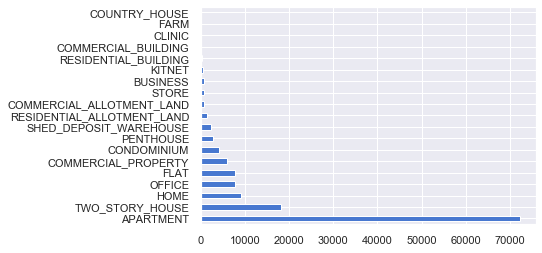

In [27]:
train_imp.unitTypes.value_counts().plot.barh()
display(test_imp.unitTypes.nunique())
display(train_imp[train_imp.unitTypes == 'APARTMENT'].describe().T)
display(test_imp.describe().T)

In [28]:
# remover tudo que não são apartamentos
train_imp = train_imp[train_imp.unitTypes == 'APARTMENT']
train_imp.reset_index(drop=True, inplace=True)
train_imp = train_imp.drop(labels='unitTypes', axis=1)
test_imp = test_imp.drop(labels='unitTypes', axis=1)
print(train_imp.shape,test_imp.shape)

(72241, 23) (16036, 23)


In [29]:
#categorizando missings
train_imp['pricingInfos.period'] = train_imp['pricingInfos.period'].fillna('missing')
test_imp['pricingInfos.period'] = test_imp['pricingInfos.period'].fillna('missing')
train_imp['pricingInfos.period'] = train_imp['pricingInfos.period'].astype('category')
test_imp['pricingInfos.period'] = test_imp['pricingInfos.period'].astype('category')
#removendo preço de test
columns_to_remove = ['address.geoLocation.location.lat', 'address.geoLocation.location.lon',
       'address.geoLocation.precision','address.zipCode', 'address.street', 
                     'pricingInfos.businessType','pricingInfos.rentalTotalPrice']
train_imp = train_imp.drop(labels=columns_to_remove, axis=1)
test_imp = test_imp.drop(labels=columns_to_remove, axis=1)
print(train_imp.shape,test_imp.shape)

(72241, 16) (16036, 16)


In [30]:
display(train_imp.loc[:,train_imp.isnull().sum() > 0].columns)
display(test_imp.loc[:,test_imp.isnull().sum() > 0].columns)

Index(['bathrooms', 'parkingSpaces', 'monthlyCondoFee', 'yearlyIptu', 'suites',
       'totalAreas', 'usableAreas'],
      dtype='object')

Index(['bathrooms', 'parkingSpaces', 'monthlyCondoFee', 'yearlyIptu', 'suites',
       'totalAreas', 'usableAreas', 'price'],
      dtype='object')

In [31]:
from feature_engine import missing_data_imputers  as msi
from feature_engine import outlier_removers as outr
nullcols = ['bathrooms', 'bedrooms', 'parkingSpaces', 'monthlyCondoFee',
                                                         'yearlyIptu', 'suites', 'totalAreas', 'usableAreas']
#Criando colunas flag onde tem nulos
addBinary_imputer = msi.AddNaNBinaryImputer(variables =nullcols )
addBinary_imputer.fit(train_imp)
train_imp = addBinary_imputer.transform(train_imp)
test_imp = addBinary_imputer.transform(test_imp)


In [32]:
test_imp.iloc[:,17:].head()

,bedrooms_na,parkingSpaces_na,monthlyCondoFee_na,yearlyIptu_na,suites_na,totalAreas_na,usableAreas_na
0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0


## Removendo os ultimos missings e preenchendo com 0, porque já foram sinalizados

In [33]:
def impute_na(ds, variable):
    #ds[variable+'_median'] = ds[variable].fillna(median)
    ds[variable] = ds[variable].fillna(0) 
    
def fillNas(train,test):
    isNullNumericCols = train.loc[:,train.isna().any()].select_dtypes(include=np.number).columns
    for col in isNullNumericCols:
        #median = train[col].median()
        impute_na(train,col)
        #a mediana de treino deve ser passada para teste
        impute_na(test,col)

train_nomiss = train_imp.copy()
test_nomiss = test_imp.copy()
        
fillNas(train_nomiss, test_nomiss) 

In [36]:
print(train_nomiss.shape)
print(test_nomiss.shape)

(72241, 24)
(16036, 24)


## EDA
### Variável Dependente
- A kurtosis e skewing são enormes, é impressionante, somente conseguiremos visualizar se usarmos limite, nem normalização, minmax consegue lidar muito bem com taxas tão altas

### Relações com outras variáveis
- Uma possibilidade é removermos os outliers, somente uma possibilidade tempos que avaliar
- Observem os plots de regressão, como outliers influenciam um slope totalmente diferente

In [37]:
#separando colunas numericas e transformando objetos em categoricas pois são mais rápidas
categoricals = zap.getCategoricalVars(train_nomiss)
numericals = zap.getNumericalVars(train_nomiss)
booleans = zap.getBoolVars(train_nomiss)
print(categoricals)
print(numericals)
print(booleans)

Há 7 variáveis categoricas
Há 17 variáveis numéricas
Há 0 variáveis booleans
['address.neighborhood', 'owner', 'pricingInfos.period', 'publicationType', 'publisherId', 'geohash', 'geohash_high']
['bathrooms', 'bedrooms', 'parkingSpaces', 'monthlyCondoFee', 'yearlyIptu', 'suites', 'totalAreas', 'usableAreas', 'price', 'bathrooms_na', 'bedrooms_na', 'parkingSpaces_na', 'monthlyCondoFee_na', 'yearlyIptu_na', 'suites_na', 'totalAreas_na', 'usableAreas_na']
[]


### A variável dependente

- Observe que pelo qqplot a quantidade de outliers e o skew há direita
- Vamos aplicar um log para visualizar melhor

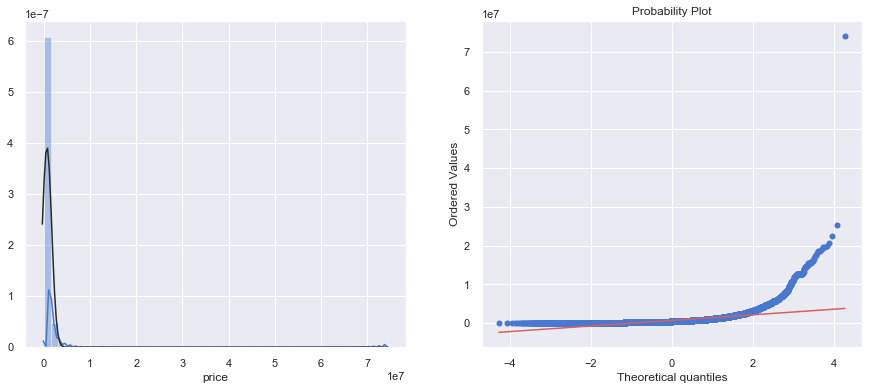

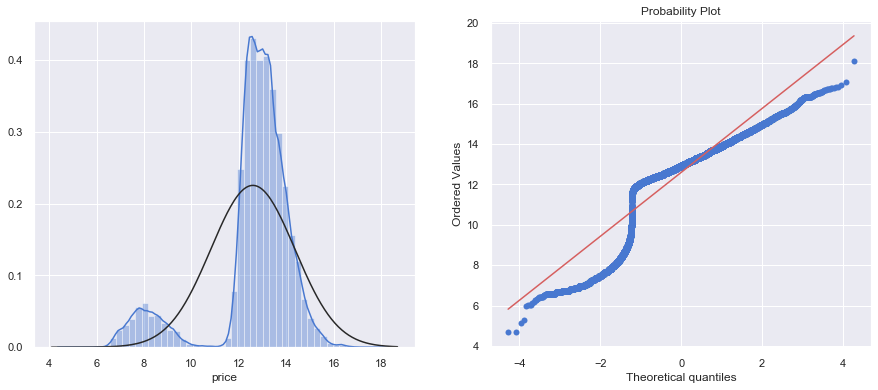

In [38]:
zap.QQ_plot(train_nomiss,'price')
zap.QQ_plot(train_nomiss,'price', np.log1p)

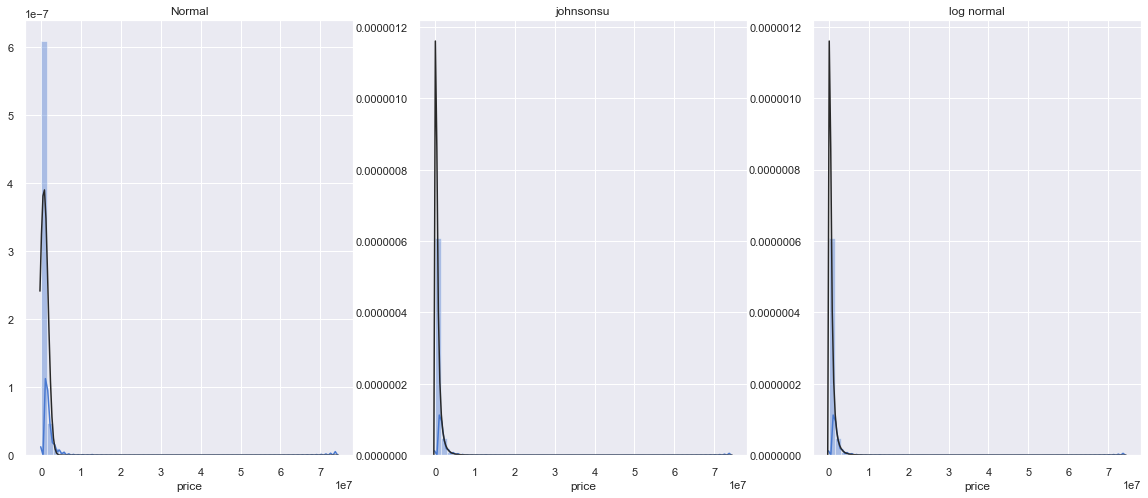

In [39]:
zap.plotDistAndLog(train_nomiss['price'])

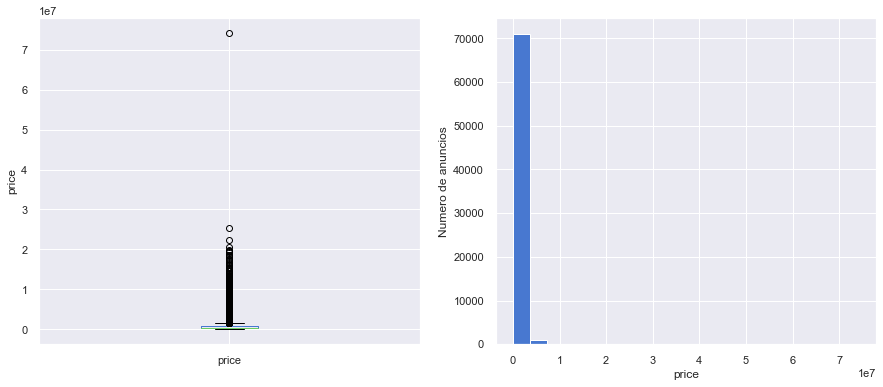

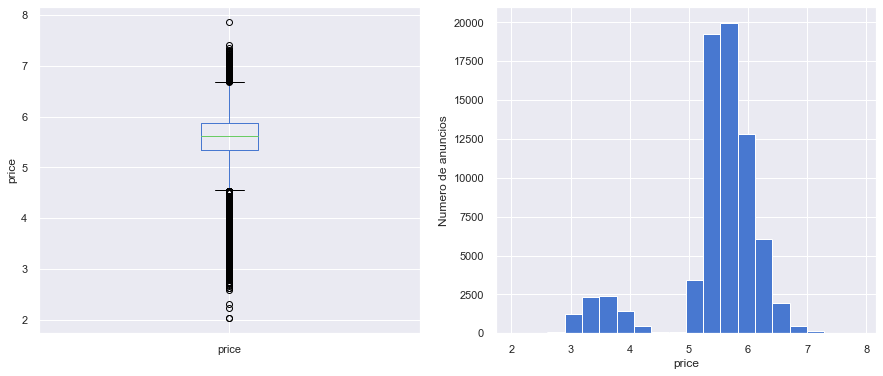

In [40]:
zap.plotBoxandHist(train_nomiss,['price'])
zap.plotBoxandHist(train_nomiss,['price'], np.log10)

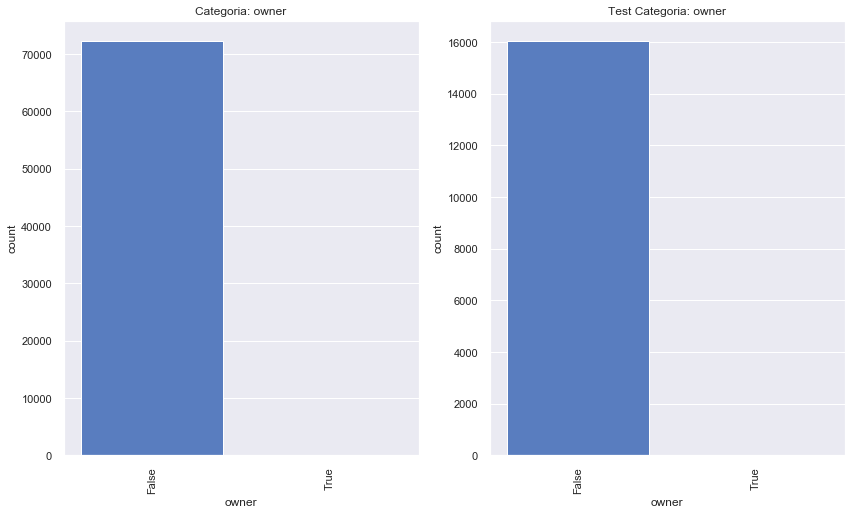

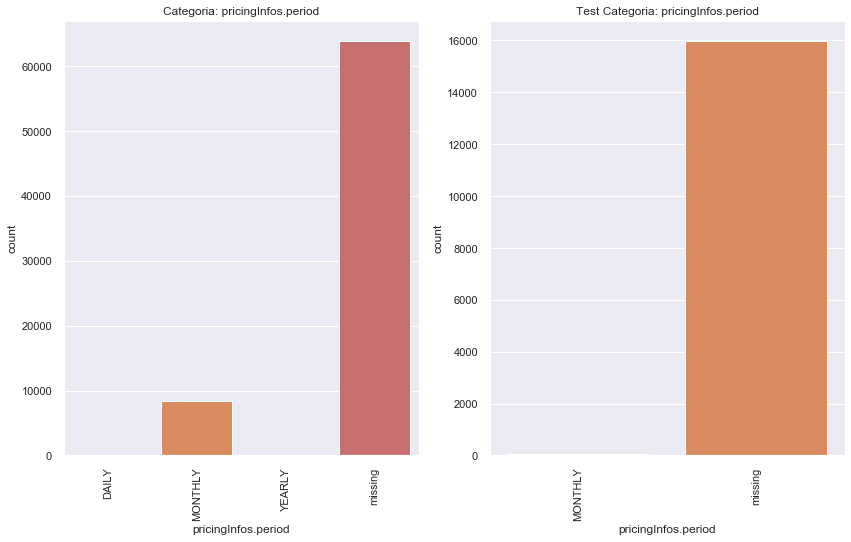

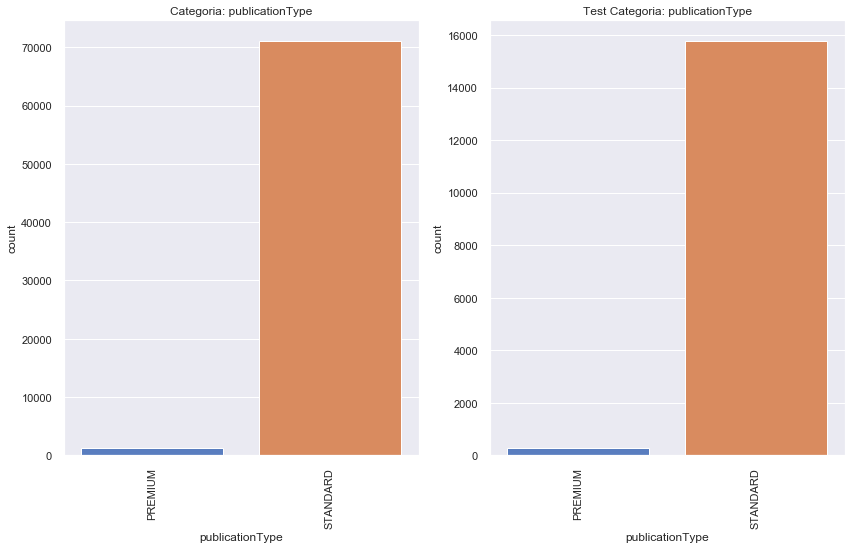

In [41]:
zap.plotBarCategories(train_nomiss,test_nomiss)

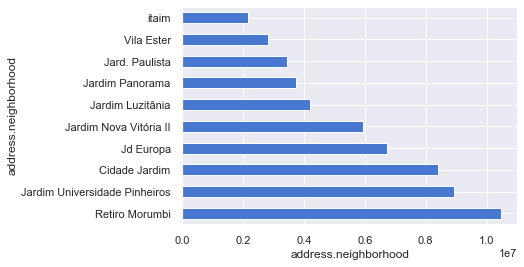

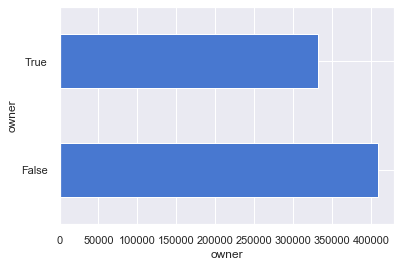

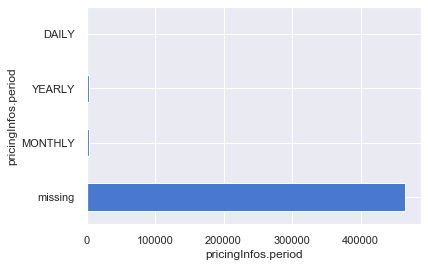

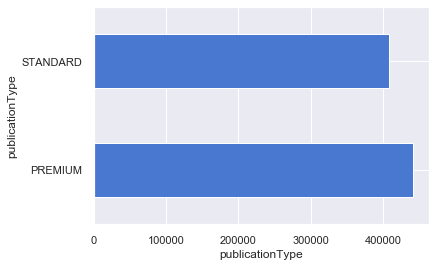

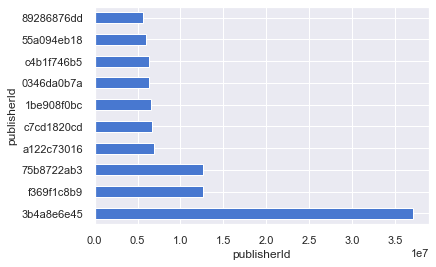

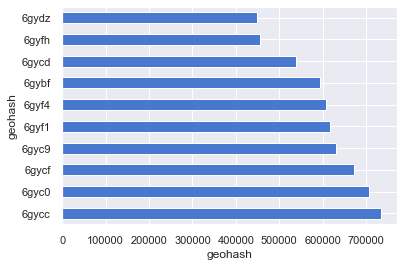

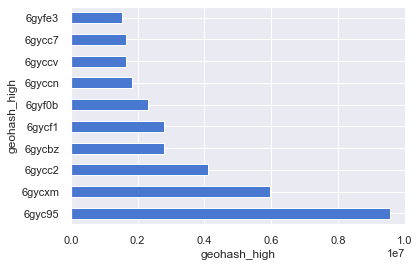

In [42]:
## Visualizando features categoricas e treino e teste
zap.plotMedianPivotTableTop10(train_nomiss,'price')


## Outliers

*Nossa base de treino está totalmente assimetrica e contem muitos outliers primeiro vou remove-los de acordo com a base de teste*

Um outlier é um ponto de dados que é significativamente distante dos dados restantes. "Um outlier é uma observação que se desvia tanto das outras observações que desperta suspeitas de que foi gerada por um mecanismo diferente." [D. Hawkins. Identificação de Outliers, Chapman e Hall, 1980].
Estatísticas como média e variância são muito suscetíveis a outliers. Além disso, alguns modelos de Aprendizado de Máquina são realmente sensíveis a valores discrepantes e seu desempenho pode ser prejudicado por eles. Assim, é prática comum projetar os recursos para minimizar o impacto de outliers no desempenho desses algoritmos.

### Natureza dos outliers

- Valores extremamente altos ou extremamente baixos
- Causado por erro mecânico (medição incorreta)
- Causado pela substituição de valores ausentes (NA) por um valor fora da distribuição 

### Como podemos pré-processar outliers?

- Média / mediana de imputação ou amostragem aleatória
- Discrestisation
- Remover os outliers: processo também chamado de Trimming
- Top-coding, bottom-coding e zero-coding: também conhecido como windsorização

### Média / mediana de imputação ou amostragem aleatória

Se tivermos razões para acreditar que os outliers são devido a erros mecânicos ou problemas durante a medição. Isso significa que, se os valores discrepantes forem de natureza semelhante a dados ausentes, qualquer um dos métodos discutidos para dados ausentes poderá ser aplicado para substituir valores discrepantes. Como o número de outliers é pequeno no contexto (caso contrário, eles não seriam outliers), é razoável usar a média / média de imputação para substituí-los.

### Discretização
Discretização é a transformação de variáveis contínuas em variáveis discretas. Envolve a atribuição dos valores das variáveis em grupos definidos. Por exemplo, para a variável idade, poderíamos agrupar as observações (pessoas) em grupos como: 0-20, 21-40, 41-60,> 61. Esse agrupamento das variáveis em intervalos é chamado de discretização. Como você pode ver, qualquer valor de idade outlier (extremamente alto) seria incluído no grupo> 61, minimizando assim seu impacto. Discutirei mais sobre os diferentes métodos de discretização na seção "Discretização" deste curso.
### Trimming
Aparar refere-se à remoção dos valores extremos de uma amostra. Neste procedimento, os outliers são identificados e as observações removidas da amostra. No lado negativo, esses valores podem conter informações úteis para outras variáveis incluídas no conjunto de dados. Assim, provavelmente, podemos optar por não remover essas observações e lidar com valores discrepantes por codificação superior / inferior, conforme descrito abaixo.

### Top-coding, bottom-coding e zero-coding
Top-conding, amplamente utilizado em econometria e estatística, significa limitar o máximo de uma distribuição a um valor arbitrariamente definido. Uma variável top-coding é aquela para a qual os pontos de dados cujos valores estão acima de um limite superior são limitados. Isso significa, em termos práticos, que todos os valores acima da faixa superior serão arbitrariamente configurados para a faixa superior.
Top-coding é uma prática comum em dados de pesquisa, antes de ser liberada para o público. É usado para preservar o anonimato dos entrevistados. Por exemplo, quem ganha muito dinheiro pode ser facilmente identificado. Assim, ao implementar top-coding, esse valor discrepante é limitado a um determinado valor máximo e, portanto, se parece com muitas outras observações, não é mais identificável exclusivamente. Top-coding também pode ser aplicado para evitar outliers possivelmente errôneos.
Bottom-coding é análogo, mas no lado esquerdo da distribuição. Isto é, todos os valores abaixo de um certo limite são limitados a esse limite. Se o limiar é zero, então é conhecido como zero-coding, por ex. se valores abaixo de zero forem relatados como zero. Bons exemplos seriam a variável "idade" ou a variável "salário". Não é possível ter idade negativa ou salário negativo, portanto, é razoável limitar os valores mais baixos em zero. Qualquer observação com um valor abaixo de zero deve ter sido introduzida por engano.

#### Extreme Value Analysis

A forma mais básica de detecção de outliers é a análise de valor extremo de dados unidimensionais. A chave para esse método é determinar as caudas estatísticas da distribuição subjacente da variável e, em seguida, encontrar os valores que ficam no final das extremidades.

Em um cenário típico, a distribuição da variável é gaussiana e, portanto, os outliers ficarão fora da média mais ou menos 3 vezes o desvio padrão da variável.
Se a variável não for normalmente distribuída, uma abordagem geral é calcular as quantis e, em seguida, a faixa de interquantilidade (IQR), da seguinte maneira:

<code>
IQR = 75º quantil - 25º quantil
Um outlier ficará fora dos seguintes limites superior e inferior:
Limite superior = 75º quantil + (IQR * 1,5)
Limite inferior = 25º quantil - (IQR * 1,5)
ou para casos extremos:
Limite superior = 75º quantil + (IQR * 3)
Limite inferior = 25º quantil - (IQR * 3)
</code>

#### Exemplo:

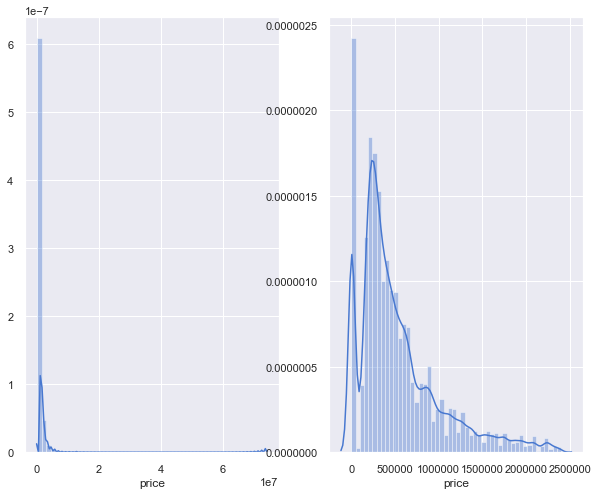

In [43]:
y = train_nomiss['price']
#sns.kdeplot(y)
IQR = y.quantile(0.75) - y.quantile(0.25)
Upper_fence = y.quantile(0.75) + (IQR * 3)
Bottom_fence = y.quantile(0.75) - (IQR * 3)
#plt.xlim=
fig, axis = plt.subplots(1,2,figsize=(10,8))
sns.distplot(y, ax=axis[0])
sns.distplot(y[(y< Upper_fence) & (y>Bottom_fence)], ax=axis[1])
#_ =axis[1].hist(y[(y< Upper_fence) & (y>Bottom_fence)])
#_ =axis[0].hist(y)    

In [45]:
y.describe()

count       72,241.000000
mean       678,399.265210
std      1,015,756.477450
min            106.000000
25%        224,000.000000
50%        409,500.000000
75%        770,000.000000
max     74,200,000.000000
Name: price, dtype: float64

In [46]:
y[(y< Upper_fence) & (y>Bottom_fence)].describe()

count      69,358.000000
mean      532,585.376842
std       475,110.134290
min           106.000000
25%       224,000.000000
50%       385,000.000000
75%       699,300.000000
max     2,401,000.000000
Name: price, dtype: float64

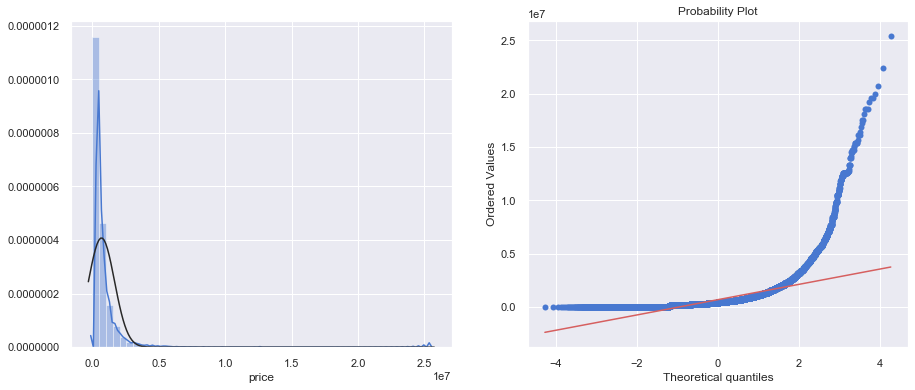

In [47]:
#removendo apenas 1 outlier
train_nomiss = train_nomiss[y < 30000000]
train_nomiss.reset_index(drop=True, inplace=True)
zap.QQ_plot(train_nomiss,'price')

### Analizando Windsoriser

{'price': 4592000.0}
4592000.0


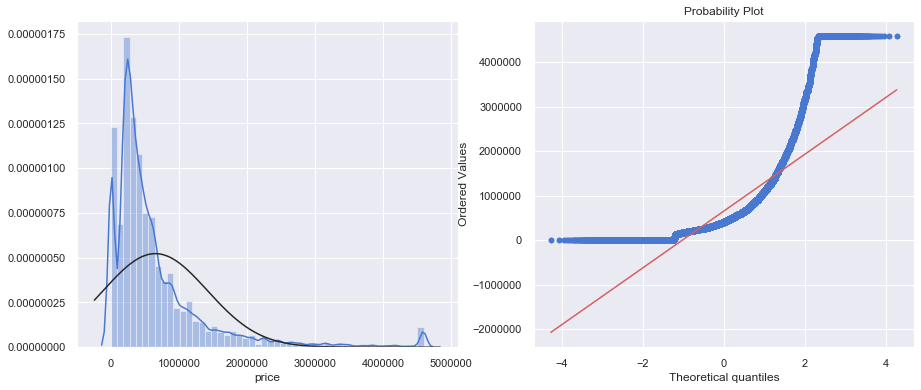

count      72,240.000000
mean      651,399.167179
std       763,169.632199
min           106.000000
25%       224,000.000000
50%       409,500.000000
75%       770,000.000000
max     4,592,000.000000
Name: price, dtype: float64


In [48]:
from feature_engine import outlier_removers as outr
windsoriser = outr.Windsorizer(distribution='skewed', tail='right', fold=7, variables = ['price'])
windsoriser.fit(train_nomiss)
# here we can find the maximum caps allowed
print(windsoriser.right_tail_caps_)
data = windsoriser.transform(train_nomiss)
# let's check the new maximum Age and maximum Fare in the titanic
print(data.price.max())
zap.QQ_plot(data,'price')
print(data.price.describe())
del data

## Visualizando features numéricas

- Bathrooms


In [49]:
#função para facilitar a analise
def univariateAnalizeVar(df,dftest, serie):
    display(df[serie].describe(percentiles=[.25,.5,.76,.99]))
    display(dftest[serie].describe(percentiles=[.25,.5,.76,.99]))
    #zap.runSimpleRegression(df,serie) #vai ser usada na segunda fase de análise
    zap.QQ_plot(df,serie,title1="Treino",title2="Prob Treino")
    zap.QQ_plot(dftest,serie, title1="Test",title2="Prob Test")
    zap.plotDistributions(df, dftest,serie)
def plotTransformations(var):
    zap.QQ_plot(train_nomiss,var, np.log1p, title1="LogTrans") 
    zap.QQ_plot(train_nomiss,var, lambda x: boxcox1p(x, boxcox_normmax(x + 1)),title1="Boxcox") 
    zap.QQ_plot(train_nomiss,var, lambda x: 1/(x+1), title1="Reciprocal") 
    zap.QQ_plot(train_nomiss,var, lambda x: x**(1/2), title1="Raiz") 
    zap.QQ_plot(train_nomiss,var, lambda x: x**(1/5), title1="Exponencial") 

count   72,240.000000
mean         2.309413
std          1.704096
min          0.000000
25%          1.000000
50%          2.000000
76%          3.000000
99%          6.000000
max         99.000000
Name: bathrooms, dtype: float64

count   16,036.000000
mean         2.257047
std          1.670755
min          0.000000
25%          1.000000
50%          2.000000
76%          3.000000
99%          6.000000
max         99.000000
Name: bathrooms, dtype: float64

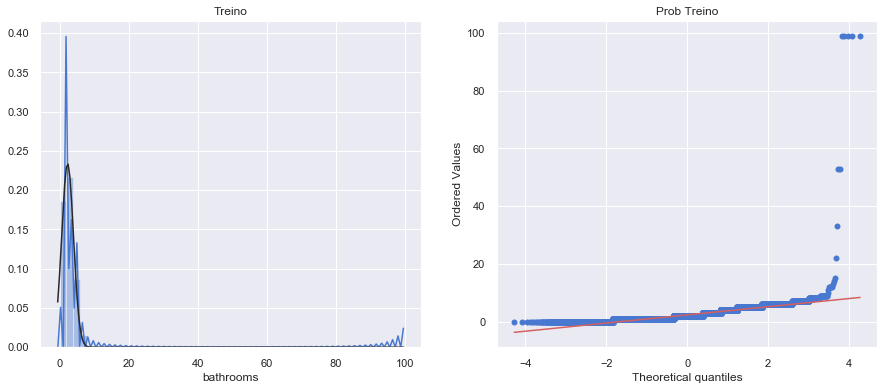

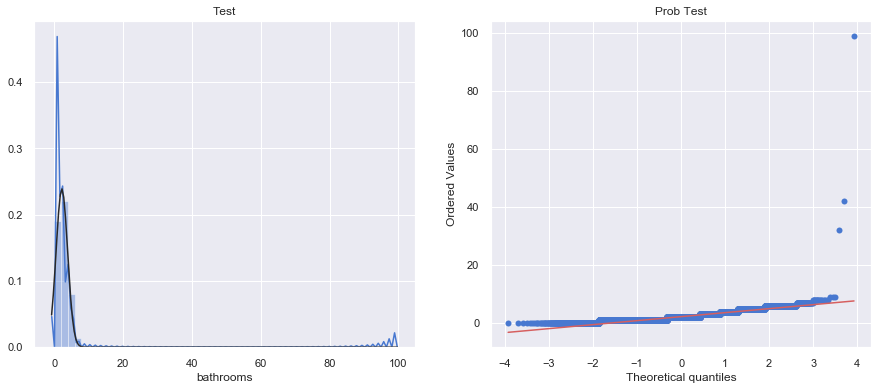

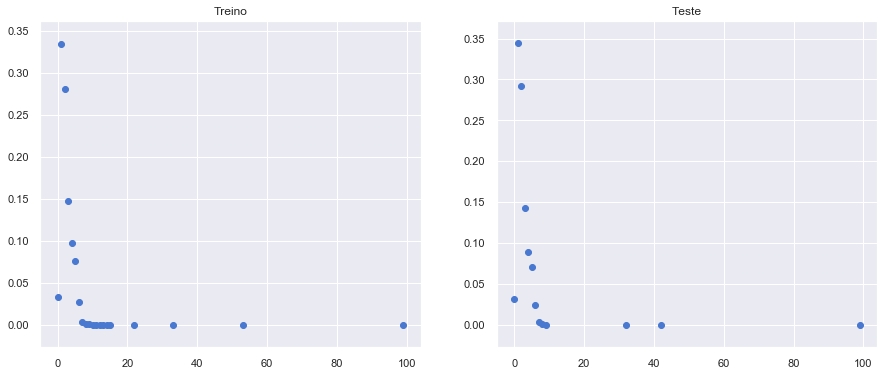

In [50]:
univariateAnalizeVar(train_nomiss,test_nomiss,'bathrooms')

In [51]:
# bathrooms
bathfilter = (train_nomiss['bathrooms'] <= 50)
display(train_nomiss.loc[~bathfilter,['bathrooms','price']].dropna().sort_values(by='price',ascending=True))
display(test_nomiss[test_nomiss['bathrooms'] >= 50])

,bathrooms,price
25967,99.000000,4200
2523,99.000000,1050000
2798,53.000000,1050000
37523,99.000000,1064000
33024,99.000000,1372000
30450,99.000000,1400000
57556,53.000000,1470000


,address.neighborhood,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,pricingInfos.period,yearlyIptu,publicationType,publisherId,suites,totalAreas,usableAreas,price,geohash,geohash_high,bathrooms_na,bedrooms_na,parkingSpaces_na,monthlyCondoFee_na,yearlyIptu_na,suites_na,totalAreas_na,usableAreas_na
5700,Santa Cecília,99.000000,1,False,1.000000,875.000000,missing,91.000000,STANDARD,e196a2927f,0.000000,42.000000,42.000000,None,6gyf4,6gyf46,0,0,0,0,0,0,0,0


In [52]:
train_nomiss['bathrooms'].iloc[44427] = train_nomiss['bathrooms'].median()
train_nomiss.reset_index(drop=True, inplace=True)

In [53]:
test_nomiss['bathrooms'].iloc[5700] = test_nomiss['bathrooms'].median()
test_nomiss.reset_index(drop=True, inplace=True)

In [54]:
print(train_nomiss.bathrooms.iloc[4427])
print(test_nomiss.bathrooms.iloc[5700])

2.0
2.0


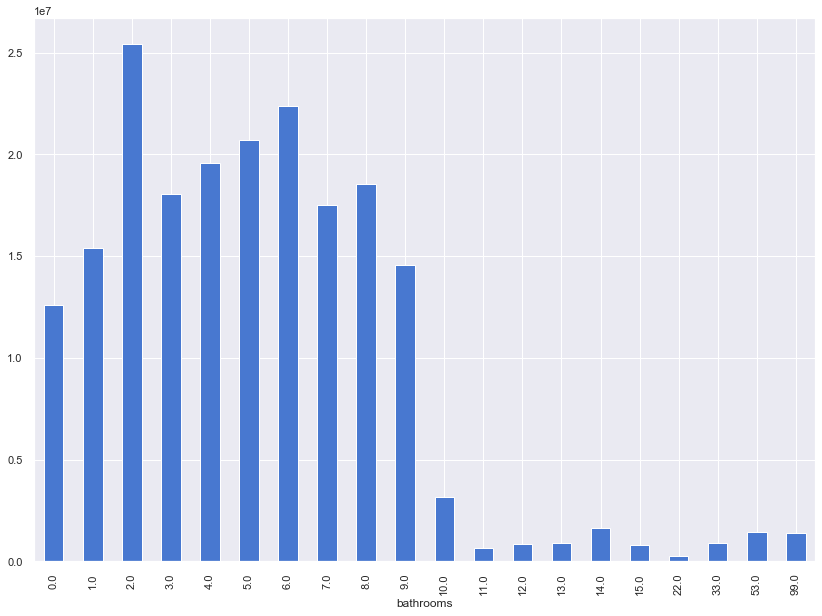

In [55]:
train_nomiss.groupby('bathrooms')['price'].max().plot.bar(figsize=(14,10))

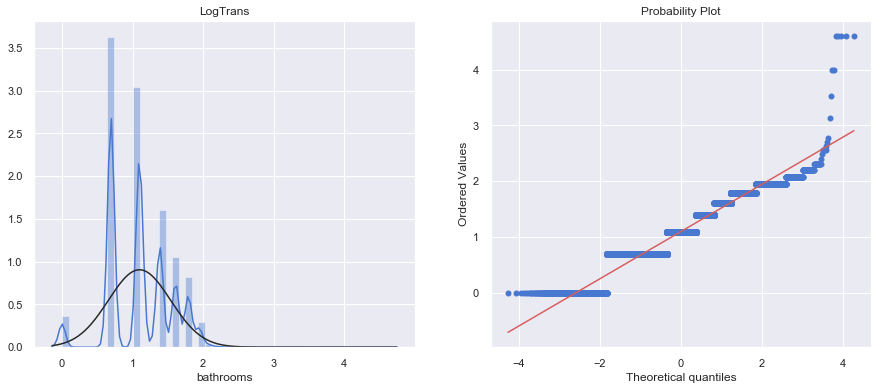

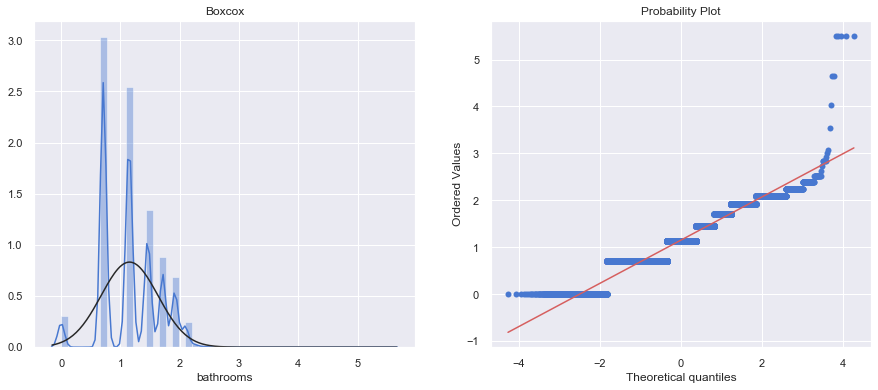

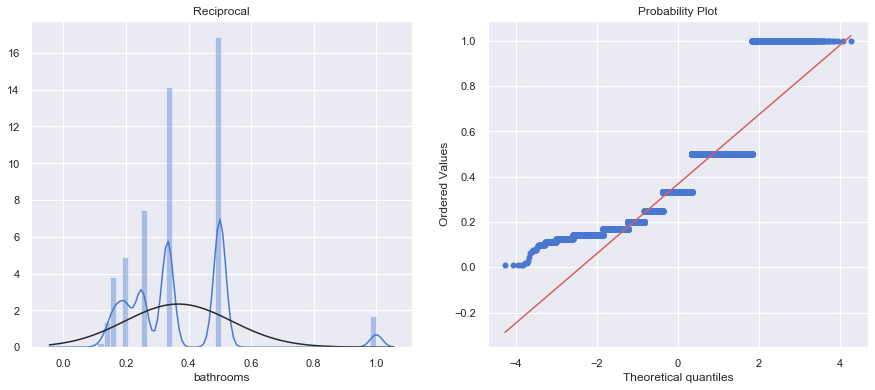

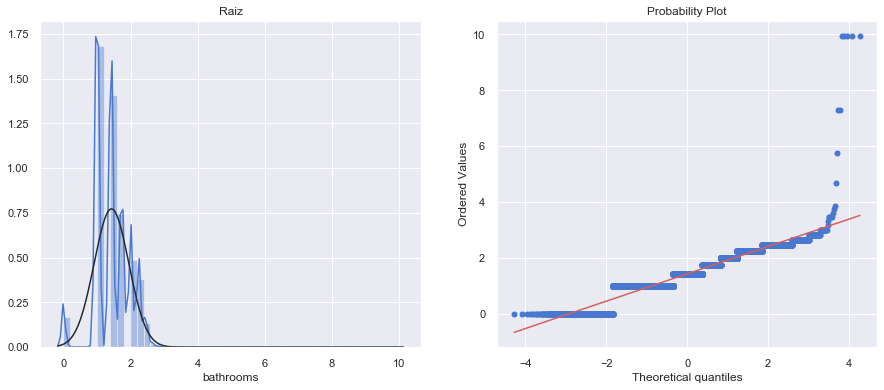

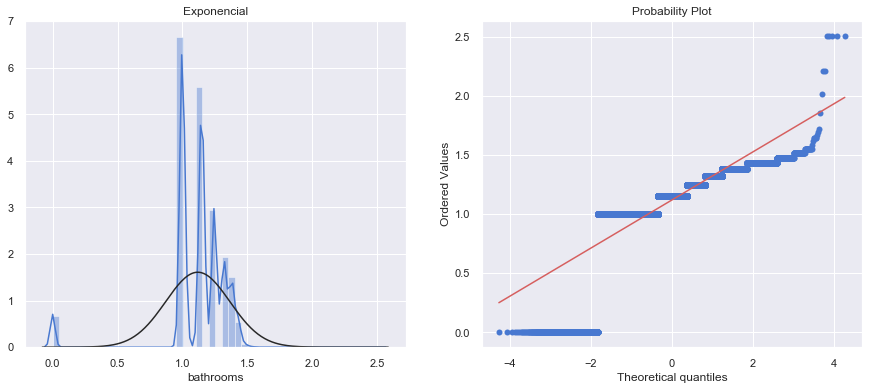

In [56]:
plotTransformations('bathrooms')

### Esta função chama 3 regressores StatsModel, Random Forest e GBM

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                 1.400e+04
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:12:45   Log-Likelihood:            -1.0925e+06
No. Observations:               72240   AIC:                         2.185e+06
Df Residuals:                   72238   BIC:                         2.185e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.432e+05   5610.417     25.527      0.000    1.32e+05    1.54e+05
bathrooms   2.313e+05   1954.798    118.322      0.000    2.27e+05    2.35e+05
==============================================================================
Omnibus:                    83482.120   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         38087020.101
Skew:                           5.523   Prob(JB):                         0.00
Kurtosis:                     114.944   Cond. No.                         5.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Valores
RF-MAE,"390,915.721436"
RF-MSE,"632,844,698,313.831421"
RF-R2,0.284814
GBM-MAE,"391,070.502905"
GBM-MSE,"632,806,535,546.416016"
GBM-R2,0.284857


,rf_importance
bathrooms,1.000000


,rf_importance
bathrooms,1.000000


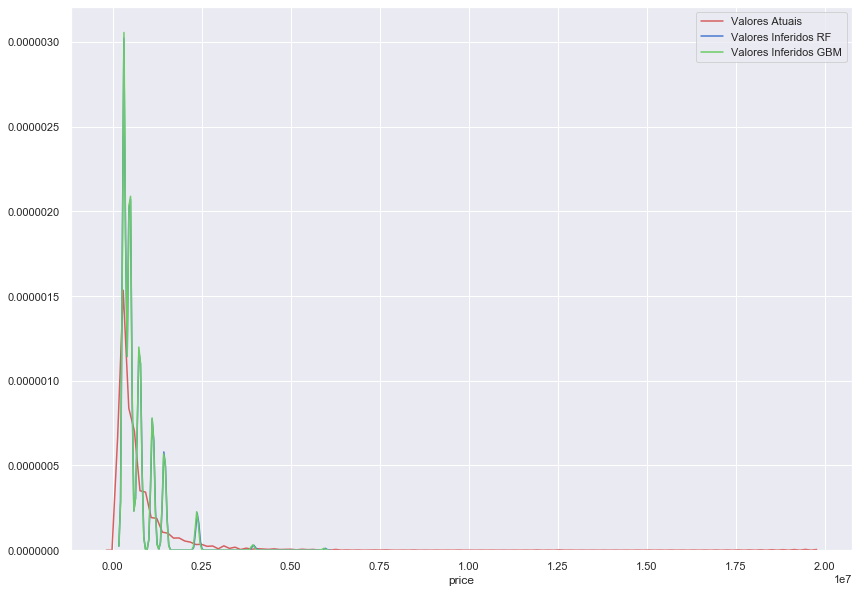

In [57]:
def showRegressions(var):
    newdf = train_nomiss.copy()
    y= newdf['price']
    X = newdf[[var]]
    zap.runMultiRegression(newdf,"price ~ "+var)
    zap.plotMetricsImportance(X,y)
    #zap.runGBMRegressor(X,y)
    del newdf,X,y

showRegressions('bathrooms')

## Bedrooms

count   72,240.000000
mean         2.591058
std          0.873250
min          0.000000
25%          2.000000
50%          3.000000
76%          3.000000
99%          4.000000
max         30.000000
Name: bedrooms, dtype: float64

count   16,036.000000
mean         2.581754
std          0.976679
min          0.000000
25%          2.000000
50%          3.000000
76%          3.000000
99%          4.000000
max         54.000000
Name: bedrooms, dtype: float64

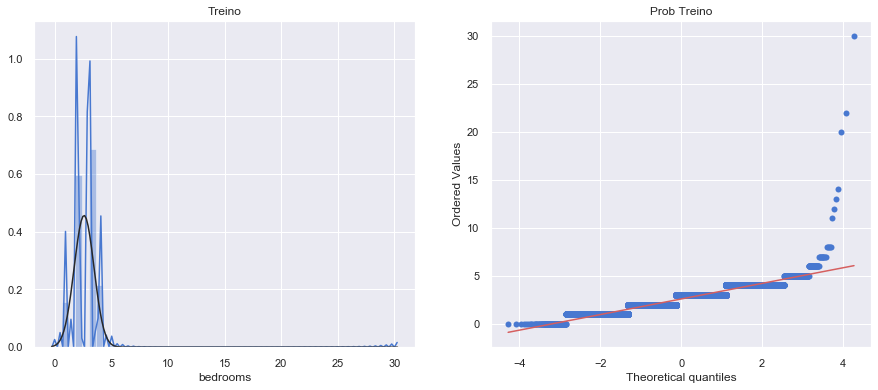

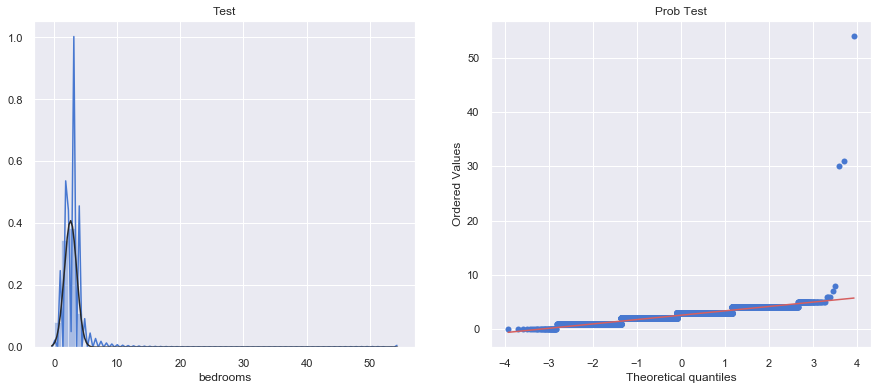

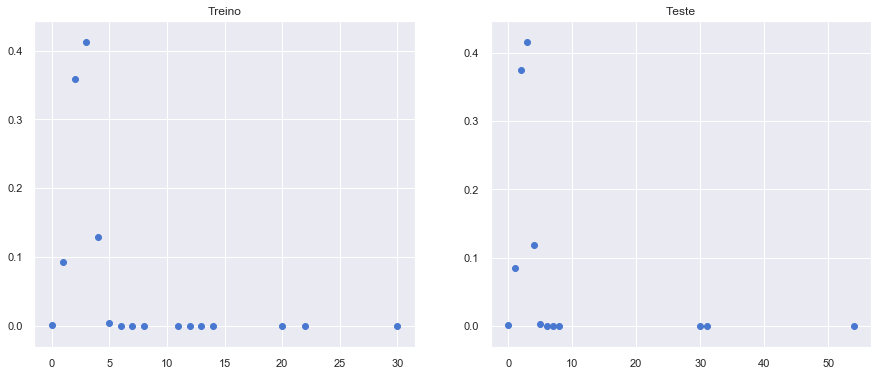

In [58]:
univariateAnalizeVar(train_nomiss,test_nomiss,'bedrooms')

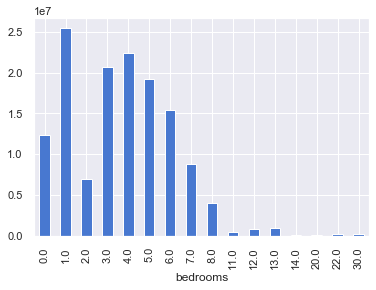

In [59]:
train_nomiss.groupby('bedrooms')['price'].max().plot.bar()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                 1.280e+04
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:13:03   Log-Likelihood:            -1.0931e+06
No. Observations:               72240   AIC:                         2.186e+06
Df Residuals:                   72238   BIC:                         2.186e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.489e+05   1.05e+04    -42.738      0.000   -4.69e+05   -4.28e+05
bedrooms    4.347e+05   3841.385    113.156      0.000    4.27e+05    4.42e+05
==============================================================================
Omnibus:                    89700.390   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23524859.006
Skew:                           6.598   Prob(JB):                         0.00
Kurtosis:                      90.415   Cond. No.                         9.60
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Valores
RF-MAE,"428,728.537970"
RF-MSE,"707,690,812,326.370239"
RF-R2,0.200229
GBM-MAE,"428,640.934539"
GBM-MSE,"707,312,139,004.984497"
GBM-R2,0.200657


,rf_importance
bedrooms,1.000000


,rf_importance
bedrooms,1.000000


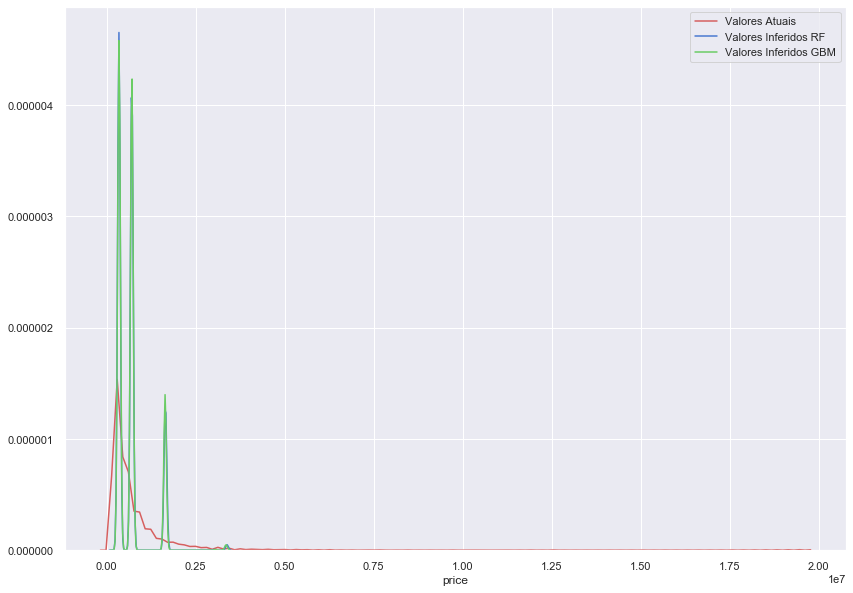

In [60]:
showRegressions('bedrooms')

## ParkingSpaces

count   72,240.000000
mean         1.768439
std          1.774386
min          0.000000
25%          1.000000
50%          1.000000
76%          2.000000
99%          5.000000
max        252.000000
Name: parkingSpaces, dtype: float64

count   16,036.000000
mean         1.710900
std          1.158845
min          0.000000
25%          1.000000
50%          1.000000
76%          2.000000
99%          5.000000
max         20.000000
Name: parkingSpaces, dtype: float64

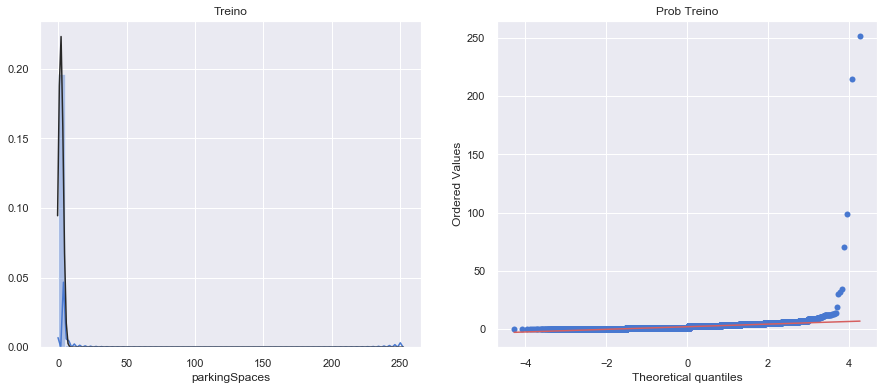

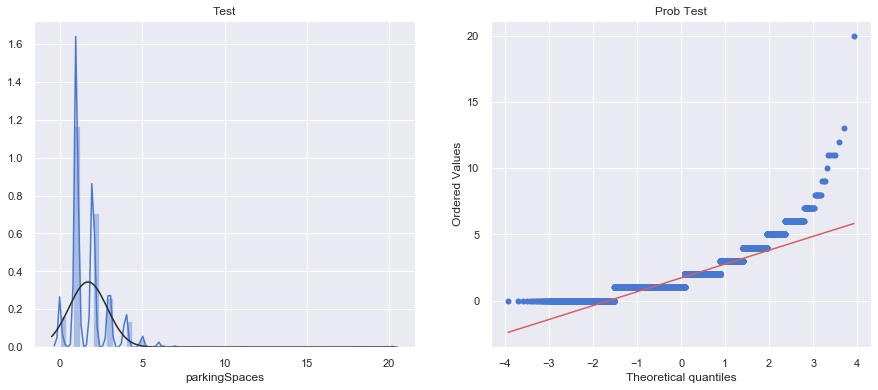

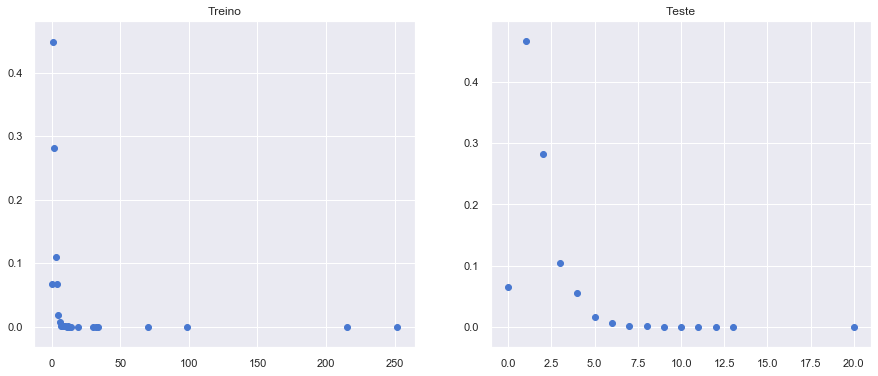

In [61]:
univariateAnalizeVar(train_nomiss, test_nomiss,'parkingSpaces')

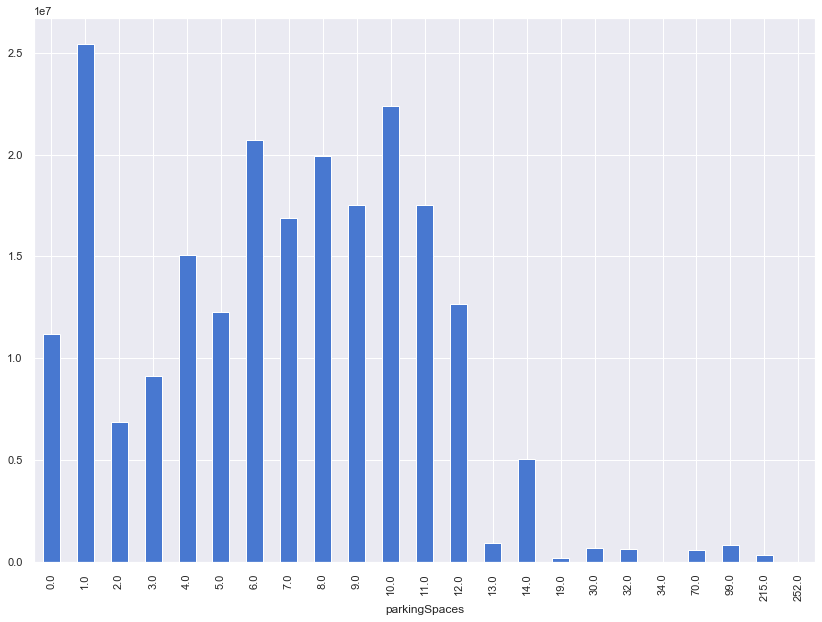

In [62]:
train_nomiss.groupby('parkingSpaces')['price'].max().plot.bar(figsize=(14,10))

In [63]:
train_nomiss = train_nomiss[train_nomiss['parkingSpaces'] <= 20]
train_nomiss.reset_index(drop=True, inplace=True)
train_nomiss.shape

(72233, 24)

count       72,233.000000
mean         1,869.298119
std         98,674.895979
min              0.000000
25%            257.000000
50%            489.000000
76%            979.000000
99%          4,200.000000
max     24,430,000.000000
Name: monthlyCondoFee, dtype: float64

count      16,036.000000
mean        1,384.333063
std        36,505.092158
min             0.000000
25%           244.000000
50%           448.000000
76%           854.000000
99%         3,972.950000
max     3,072,300.000000
Name: monthlyCondoFee, dtype: float64

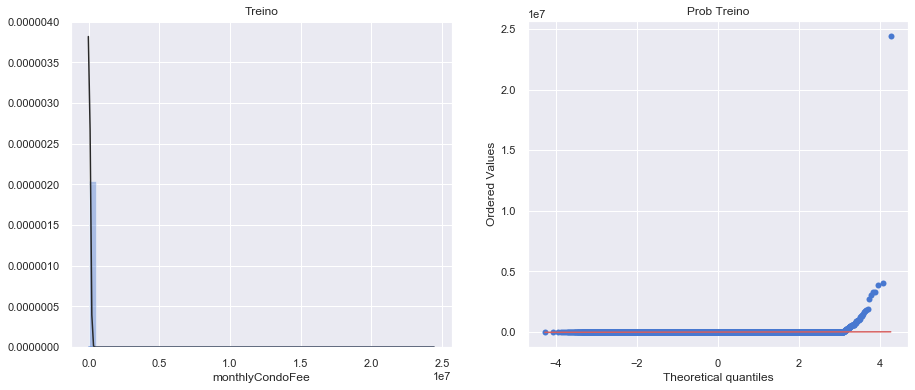

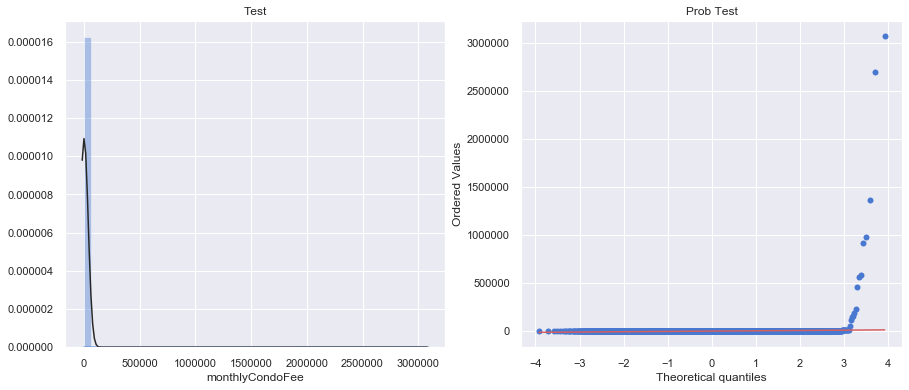

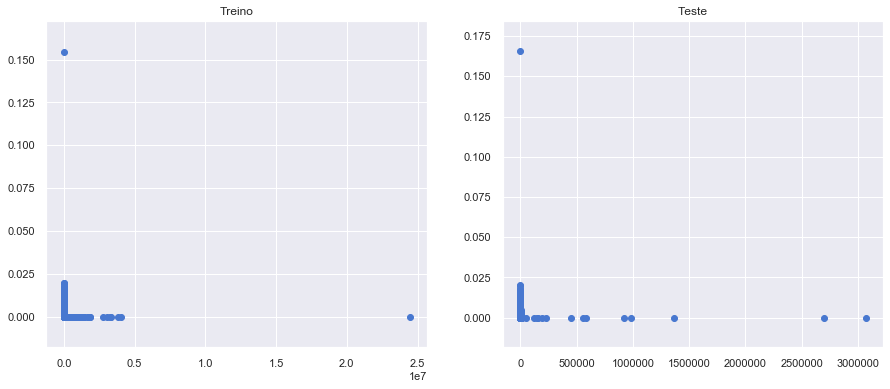

In [64]:
univariateAnalizeVar(train_nomiss, test_nomiss, 'monthlyCondoFee')

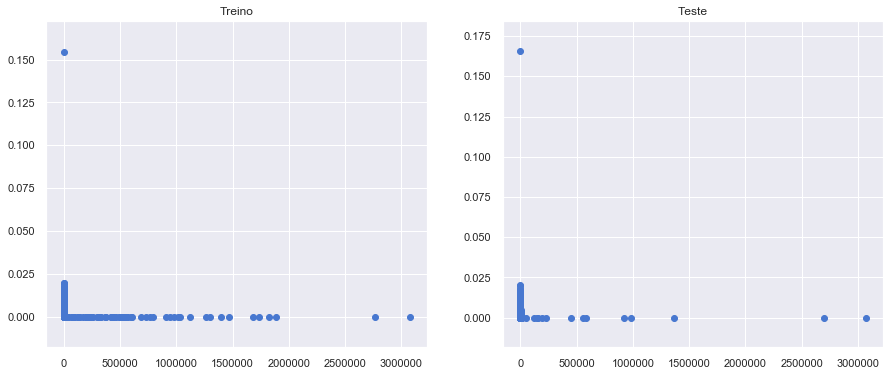

(0, 24)
(72228, 24)


In [66]:
f = train_nomiss['monthlyCondoFee']
dfe = train_nomiss[f <3172300]
zap.plotDistributions(dfe,test_nomiss,'monthlyCondoFee')
print(train_nomiss[f > 3172300].shape)
print(dfe.shape)
train_nomiss = train_nomiss[f <3172300]
train_nomiss.reset_index(drop=True, inplace=True)
del dfe
del f

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     39.26
Date:                Tue, 06 Aug 2019   Prob (F-statistic):           3.73e-10
Time:                        09:15:34   Log-Likelihood:            -1.0987e+06
No. Observations:               72228   AIC:                         2.197e+06
Df Residuals:                   72226   BIC:                         2.197e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.761e+05   3642.570    185.618      0.000    6.69e+05    6.83e+05
monthlyCondoFee     0.8372      0.134      6.266      0.000       0.575       1.099
==============================================================================
Omnibus:                    87592.877   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17072474.360
Skew:                           6.434   Prob(JB):                         0.00
Kurtosis:                      77.211   Cond. No.                     2.73e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,Valores
RF-MAE,"362,350.221811"
RF-MSE,"587,558,237,052.759521"
RF-R2,0.358535
GBM-MAE,"362,099.862178"
GBM-MSE,"553,703,277,297.967773"
GBM-R2,0.395496


,rf_importance
monthlyCondoFee,1.000000


,rf_importance
monthlyCondoFee,1.000000


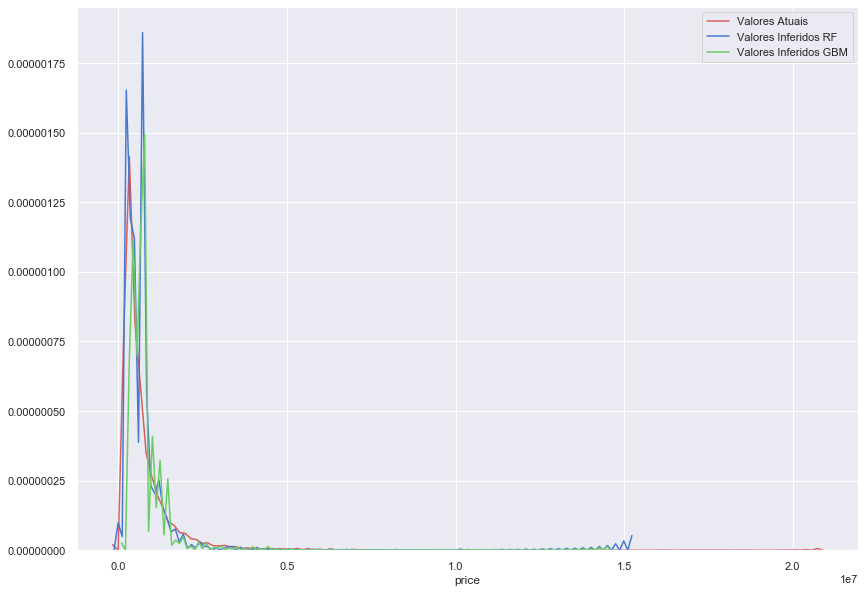

In [67]:
showRegressions('monthlyCondoFee')

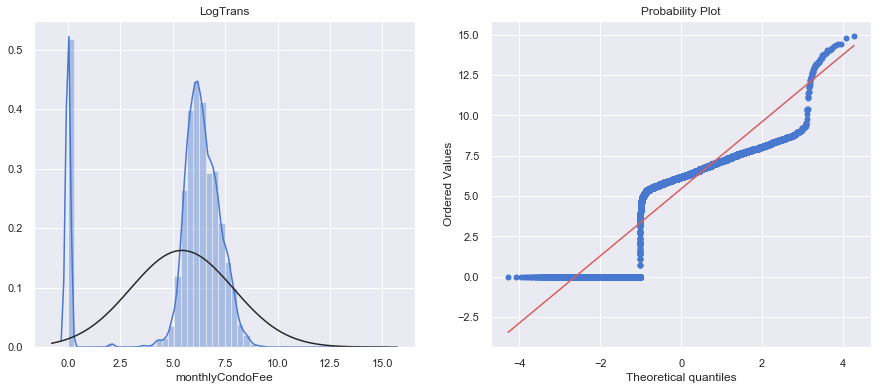

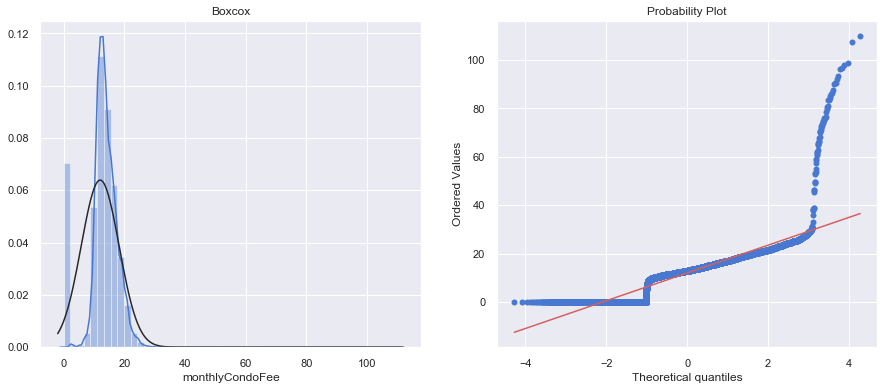

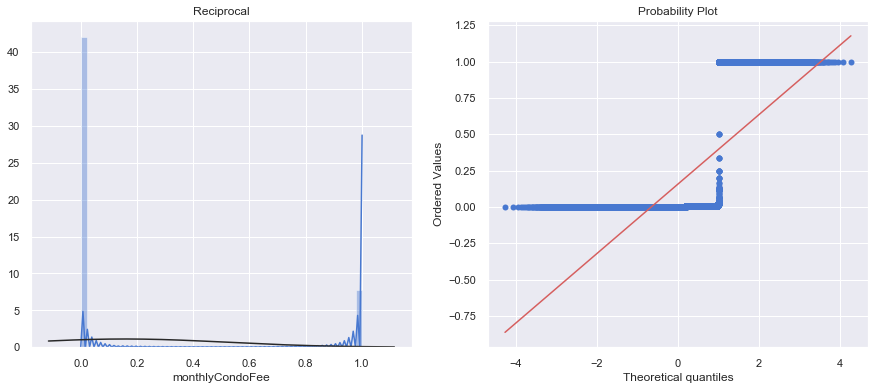

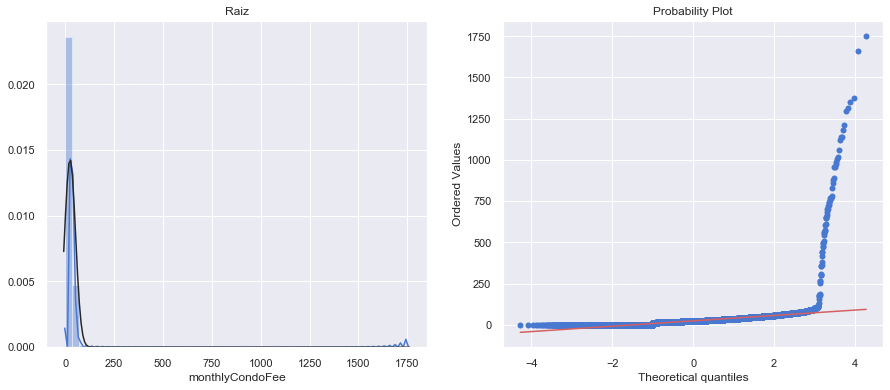

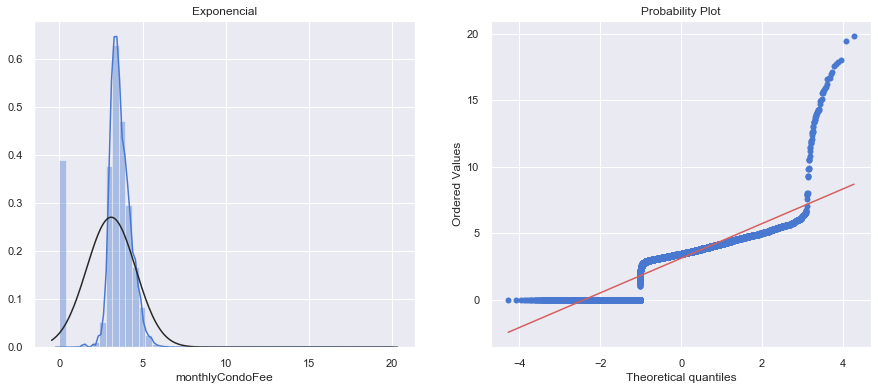

In [68]:
plotTransformations('monthlyCondoFee')

count       72,228.000000
mean           825.413759
std         50,004.397303
min              0.000000
25%              0.000000
50%             51.000000
76%            291.000000
99%          5,320.000000
max     10,367,000.000000
Name: yearlyIptu, dtype: float64

count       16,036.000000
mean         4,927.973747
std        552,908.955200
min              0.000000
25%              0.000000
50%             16.000000
76%            251.000000
99%          5,600.000000
max     70,000,000.000000
Name: yearlyIptu, dtype: float64

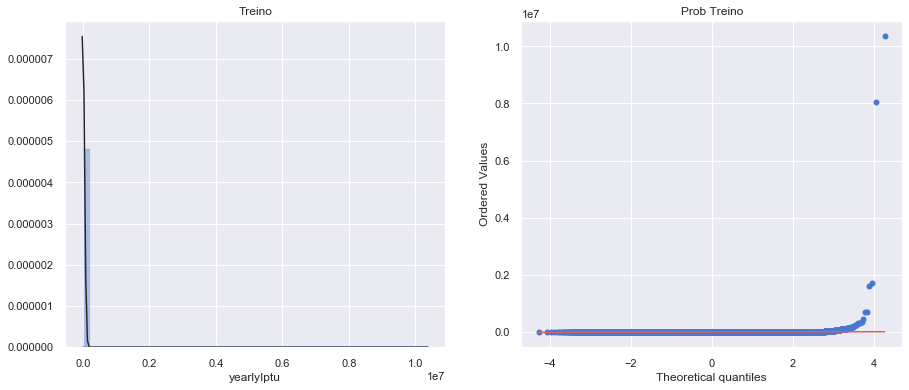

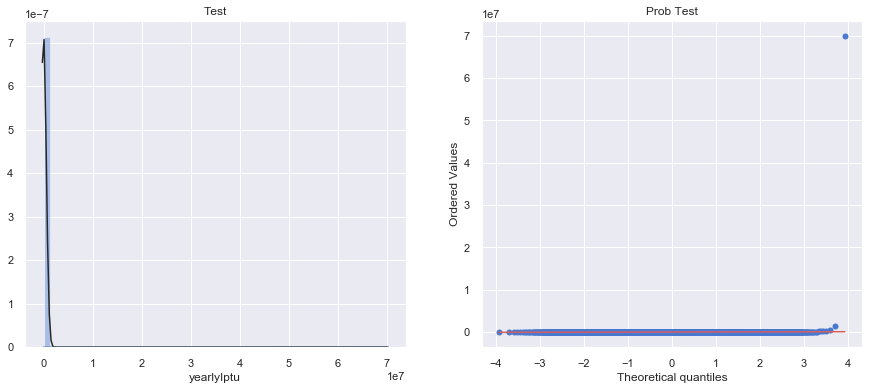

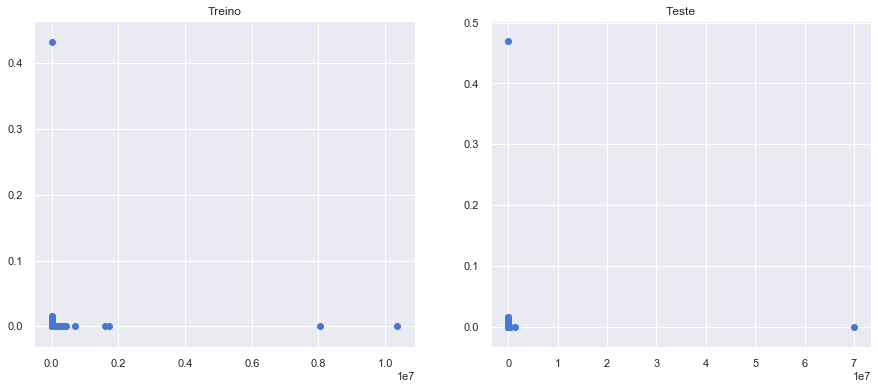

In [69]:
univariateAnalizeVar(train_nomiss, test_nomiss, 'yearlyIptu')

In [70]:
test_nomiss[test_nomiss['yearlyIptu'] > 11000000]

,address.neighborhood,bathrooms,bedrooms,owner,parkingSpaces,monthlyCondoFee,pricingInfos.period,yearlyIptu,publicationType,publisherId,suites,totalAreas,usableAreas,price,geohash,geohash_high,bathrooms_na,bedrooms_na,parkingSpaces_na,monthlyCondoFee_na,yearlyIptu_na,suites_na,totalAreas_na,usableAreas_na
8473,Sumarezinho,3.000000,3,False,3.000000,0.000000,missing,"70,000,000.000000",STANDARD,d439c09ff6,1.000000,170.000000,140.000000,None,6gyf1,6gyf13,0,0,0,0,0,0,0,0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     17.49
Date:                Tue, 06 Aug 2019   Prob (F-statistic):           2.89e-05
Time:                        09:21:57   Log-Likelihood:            -1.0987e+06
No. Observations:               72228   AIC:                         2.197e+06
Df Residuals:                   72226   BIC:                         2.198e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    6.77e+05   3639.274    186.023      0.000     6.7e+05    6.84e+05
yearlyIptu     0.3043      0.073      4.182      0.000       0.162       0.447
==============================================================================
Omnibus:                    87586.173   Durbin-Watson:                   1.762
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17060906.818
Skew:                           6.433   Prob(JB):                         0.00
Kurtosis:                      77.185   Cond. No.                     5.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,Valores
RF-MAE,"463,693.891403"
RF-MSE,"812,480,840,239.729004"
RF-R2,0.112977
GBM-MAE,"463,865.211528"
GBM-MSE,"787,897,061,255.911987"
GBM-R2,0.139816


,rf_importance
yearlyIptu,1.000000


,rf_importance
yearlyIptu,1.000000


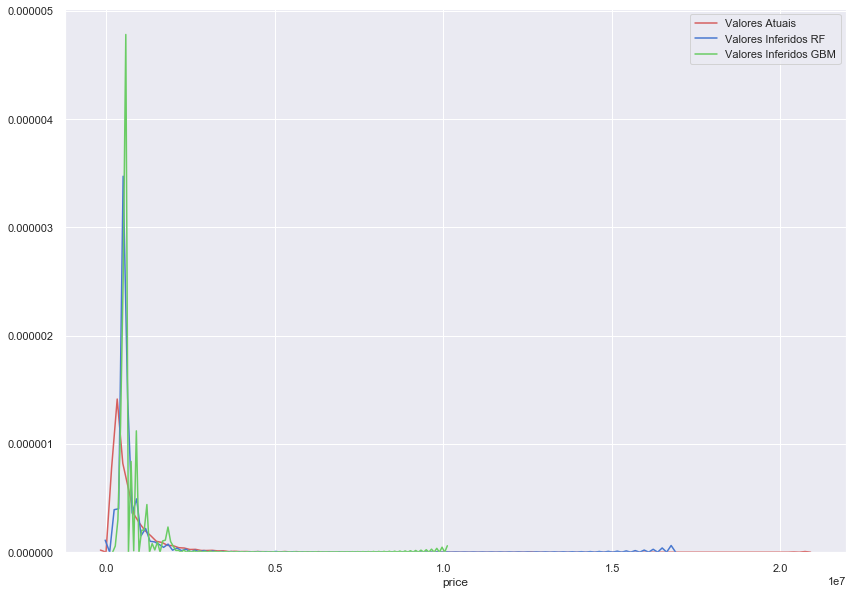

In [71]:
showRegressions('yearlyIptu')

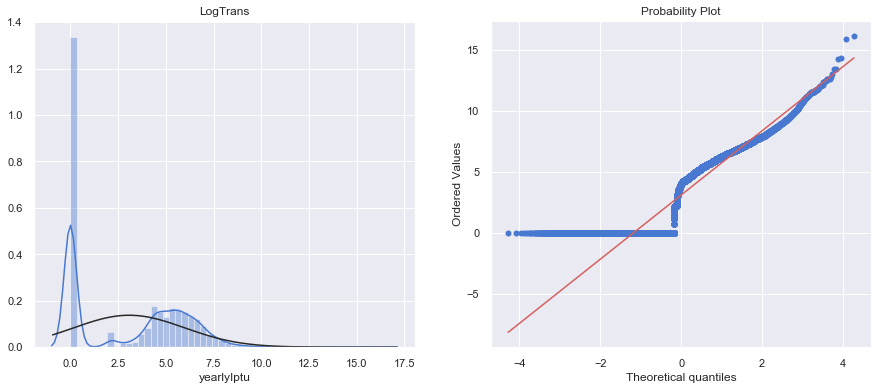

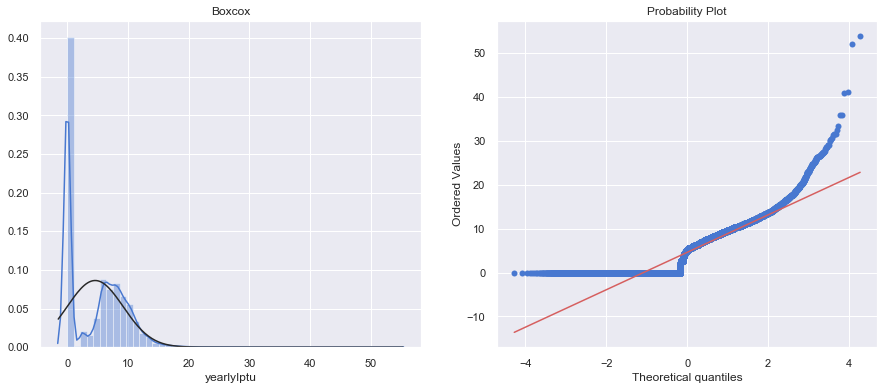

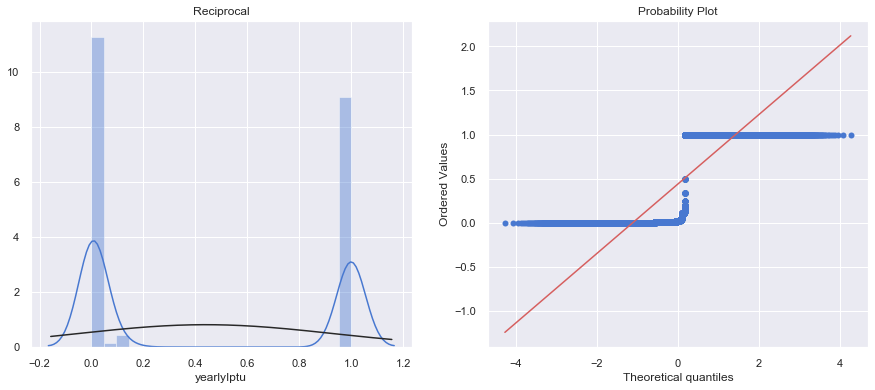

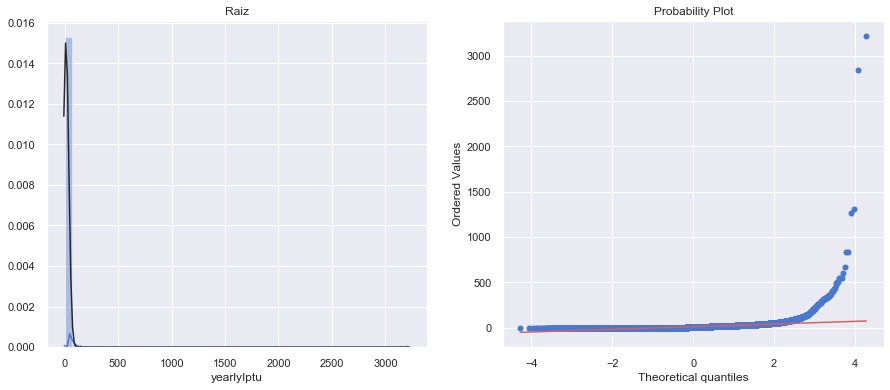

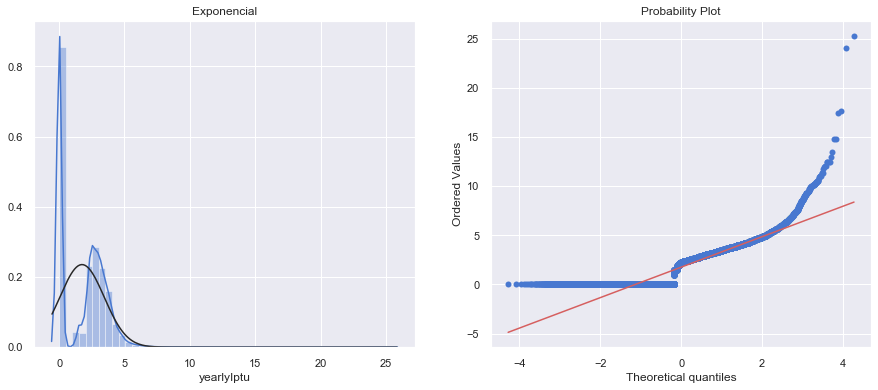

In [72]:
plotTransformations('yearlyIptu')

### Suites

count   72,228.000000
mean         1.117946
std          1.155525
min          0.000000
25%          0.000000
50%          1.000000
76%          2.000000
99%          4.000000
max         23.000000
Name: suites, dtype: float64

count   16,036.000000
mean         1.070342
std          1.125121
min          0.000000
25%          0.000000
50%          1.000000
76%          1.000000
99%          4.000000
max          5.000000
Name: suites, dtype: float64

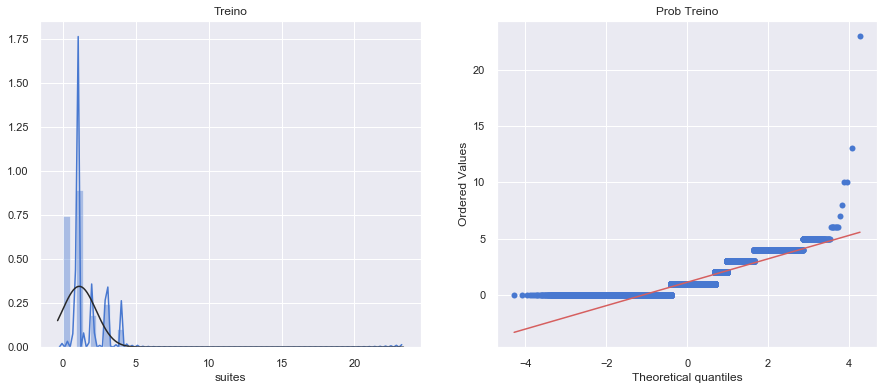

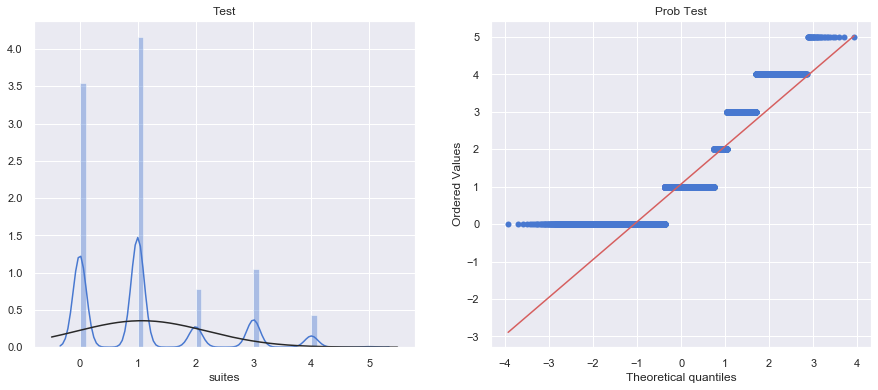

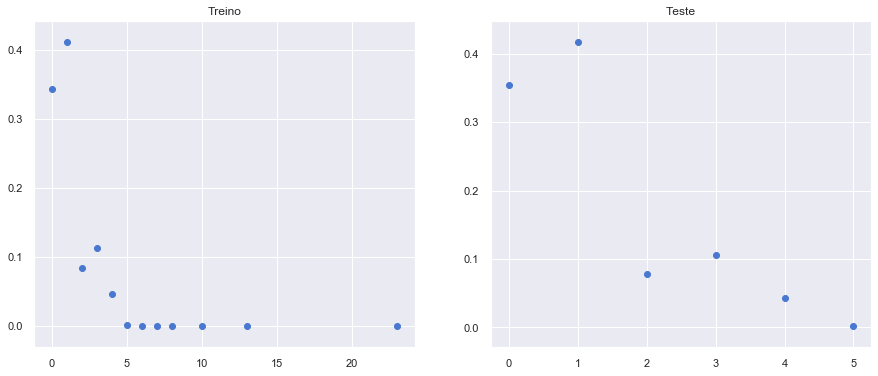

In [73]:
univariateAnalizeVar(train_nomiss, test_nomiss, 'suites')

In [74]:
display(train_nomiss.groupby('suites')['price'].count())
display(train_nomiss.groupby('suites')['price'].max())

suites
0.000000     24758
1.000000     29693
2.000000      6027
3.000000      8201
4.000000      3397
5.000000       138
6.000000         8
7.000000         1
8.000000         1
10.000000        2
13.000000        1
23.000000        1
Name: price, dtype: int64

suites
0.000000     12600000
1.000000     25434920
2.000000      9660000
3.000000     20720000
4.000000     22400000
5.000000     18550000
6.000000     12656000
7.000000      8750000
8.000000      4059999
10.000000      944999
13.000000      930999
23.000000     2029999
Name: price, dtype: int64

In [75]:
train_nomiss['suites'].dtype

dtype('float64')

In [76]:
train_nomiss.loc[train_nomiss['suites'] > 20,'suites'] = 3.
train_nomiss.reset_index(drop=True, inplace=True)
train_nomiss.loc[train_nomiss['suites'] > 10, 'suites'] = 10.
train_nomiss.reset_index(drop=True, inplace=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                 2.551e+04
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        09:23:16   Log-Likelihood:            -1.0878e+06
No. Observations:               72228   AIC:                         2.176e+06
Df Residuals:                   72226   BIC:                         2.176e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.926e+05   4358.319     44.198      0.000    1.84e+05    2.01e+05
suites      4.336e+05   2715.019    159.708      0.000    4.28e+05    4.39e+05
==============================================================================
Omnibus:                    90517.767   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28129755.891
Skew:                           6.643   Prob(JB):                         0.00
Kurtosis:                      98.763   Cond. No.                         2.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,Valores
RF-MAE,"385,720.357660"
RF-MSE,"631,134,734,736.564575"
RF-R2,0.310961
GBM-MAE,"385,683.042436"
GBM-MSE,"631,023,060,012.037231"
GBM-R2,0.311082


,rf_importance
suites,1.000000


,rf_importance
suites,1.000000


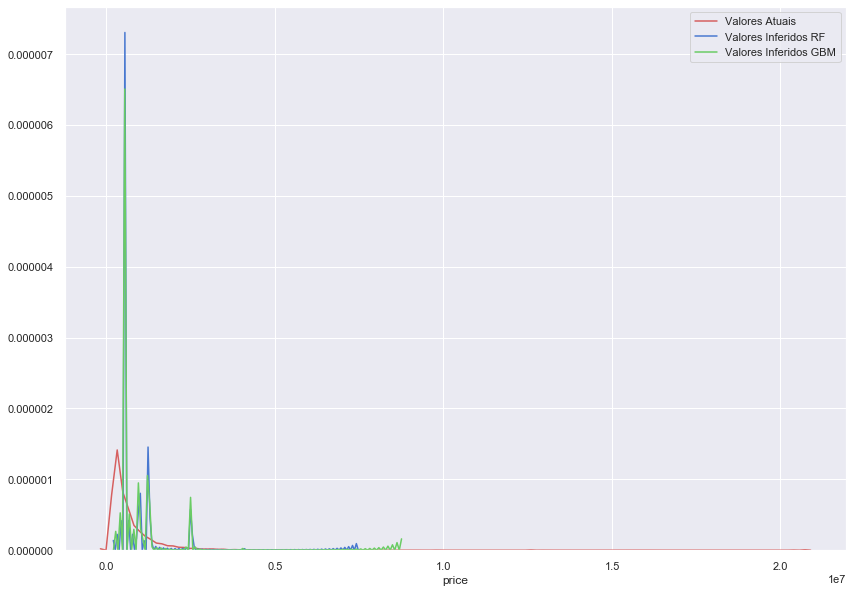

In [77]:
showRegressions('suites')

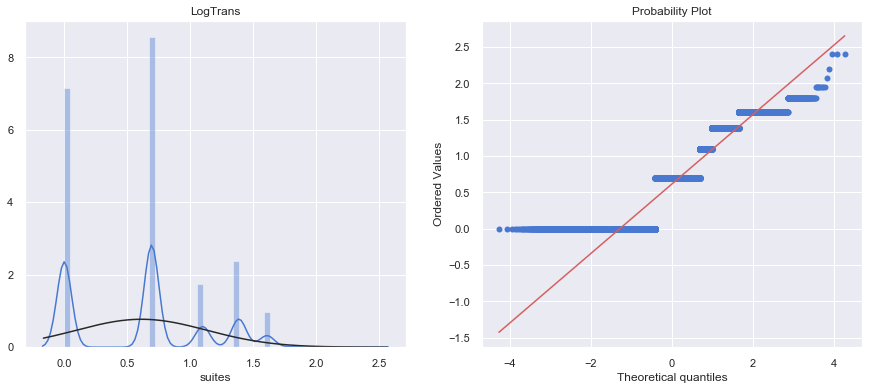

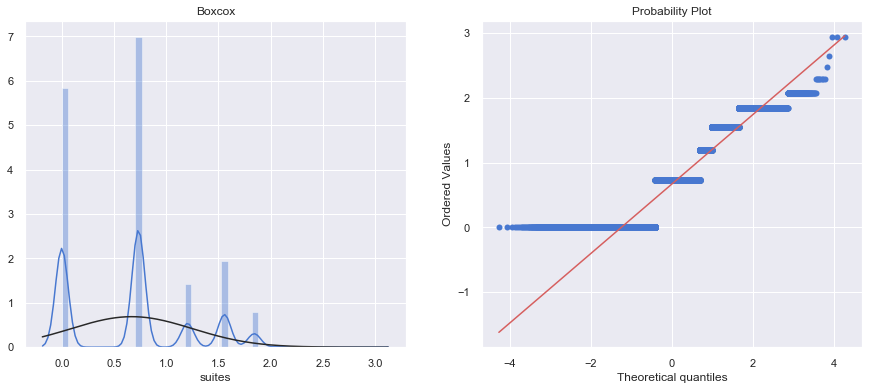

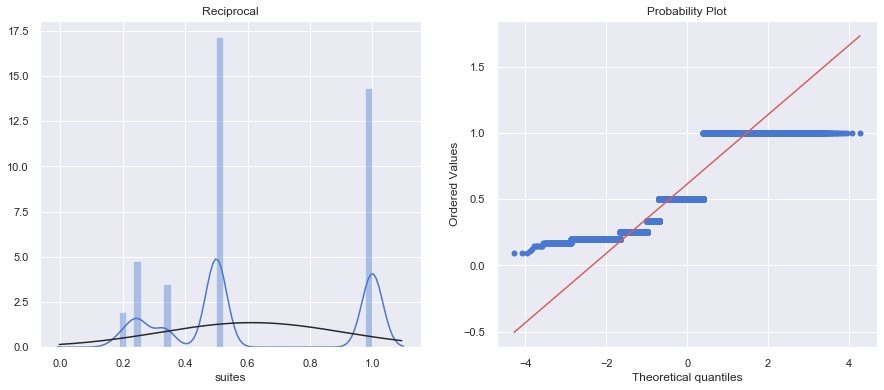

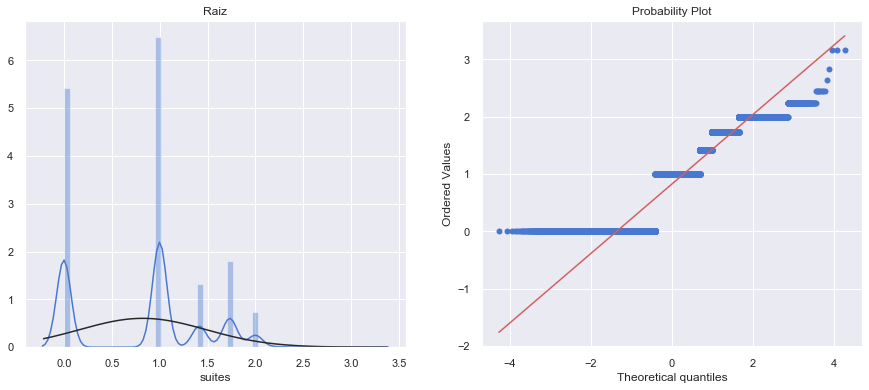

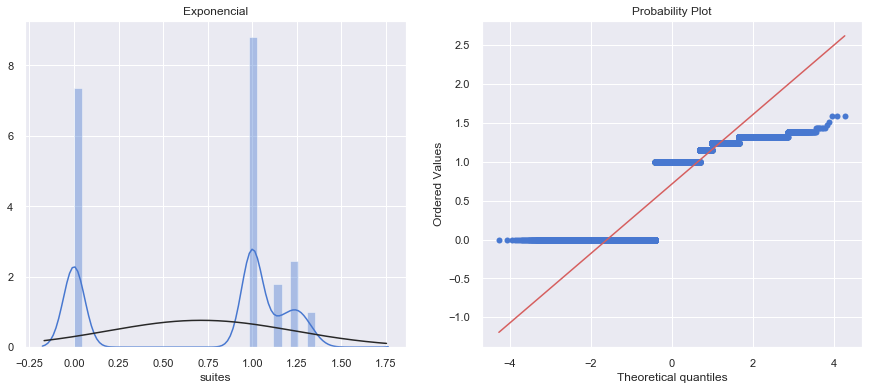

In [78]:
plotTransformations('suites')

count          72,228.000000
mean           16,362.724927
std         4,136,587.156835
min                 0.000000
25%                 0.000000
50%                50.000000
76%               117.000000
99%               911.730000
max     1,111,111,111.000000
Name: totalAreas, dtype: float64

count    16,036.000000
mean        156.529309
std       5,327.731657
min           0.000000
25%           0.000000
50%          51.000000
76%         110.000000
99%         800.000000
max     665,420.000000
Name: totalAreas, dtype: float64

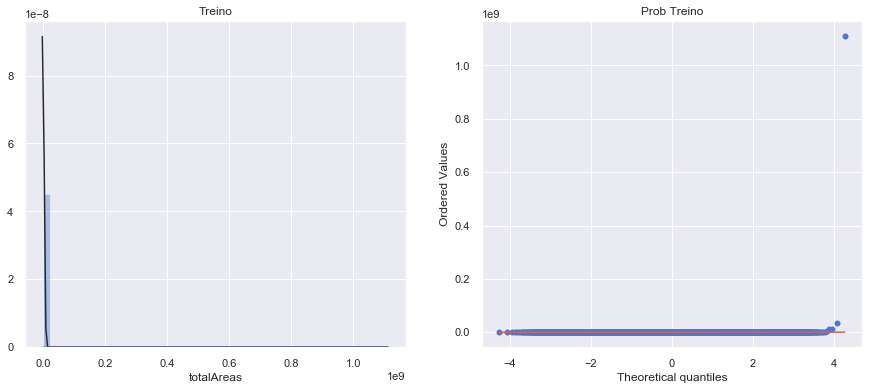

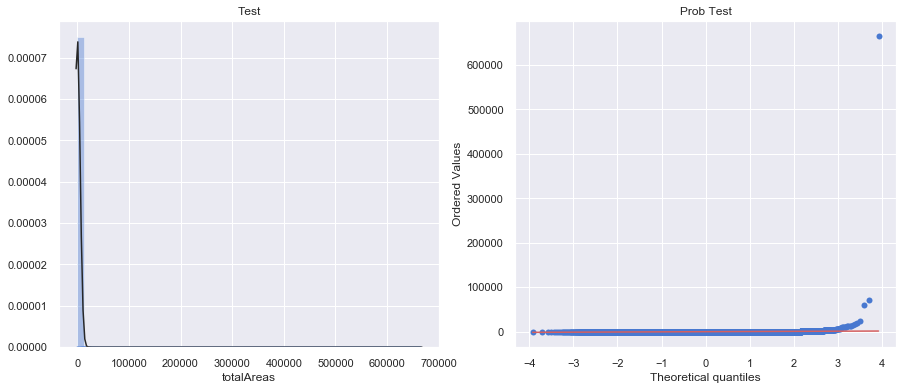

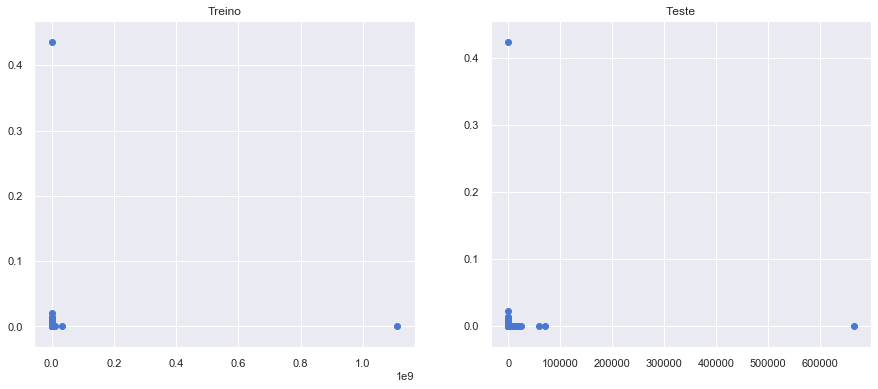

In [79]:
univariateAnalizeVar(train_nomiss, test_nomiss,'totalAreas')

In [80]:
display(train_nomiss[['totalAreas','price']].quantile([.1,.25,.50,.75,.90,.99,1]).groupby('totalAreas').max())
test_nomiss[['totalAreas']].quantile([.1,.25,.50,.75,.90,.99,1]).groupby('totalAreas').max()

,price
totalAreas,
0.000000,"224,000.000000"
50.000000,"409,326.000000"
110.000000,"770,000.000000"
234.000000,"1,470,000.000000"
911.730000,"4,550,000.000000"
"1,111,111,111.000000","25,434,920.000000"


""
totalAreas
0.000000
51.000000
107.000000
219.000000
800.000000
"665,420.000000"


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7209
Date:                Tue, 06 Aug 2019   Prob (F-statistic):              0.396
Time:                        09:23:42   Log-Likelihood:            -1.0987e+06
No. Observations:               72228   AIC:                         2.198e+06
Df Residuals:                   72226   BIC:                         2.198e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.772e+05   3639.229    186.091      0.000     6.7e+05    6.84e+05
totalAreas     0.0007      0.001      0.849      0.396      -0.001       0.002
==============================================================================
Omnibus:                    87591.629   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17064873.484
Skew:                           6.434   Prob(JB):                         0.00
Kurtosis:                      77.194   Cond. No.                     4.14e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.14e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,Valores
RF-MAE,"432,858.111462"
RF-MSE,"755,118,633,403.389893"
RF-R2,0.175602
GBM-MAE,"432,067.674160"
GBM-MSE,"731,885,308,566.408691"
GBM-R2,0.200966


,rf_importance
totalAreas,1.000000


,rf_importance
totalAreas,1.000000


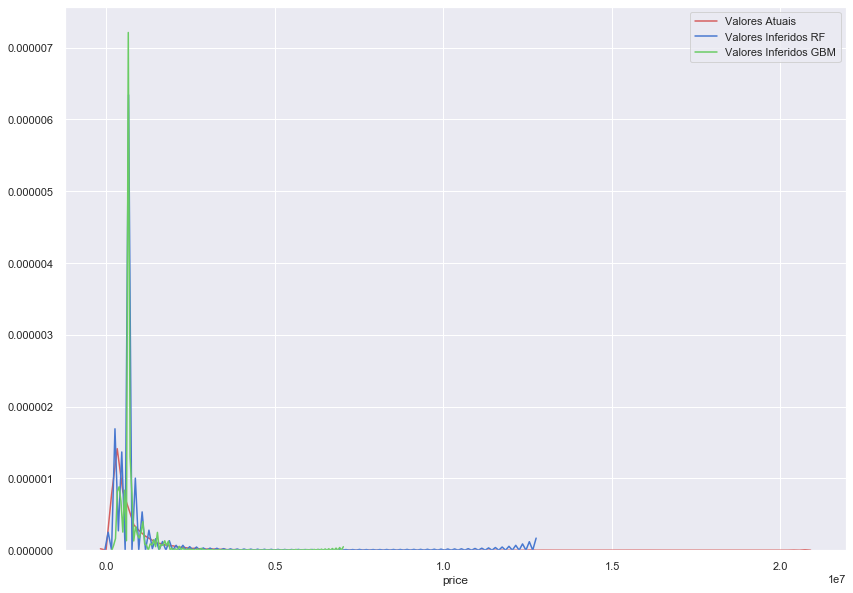

In [81]:
showRegressions('totalAreas')

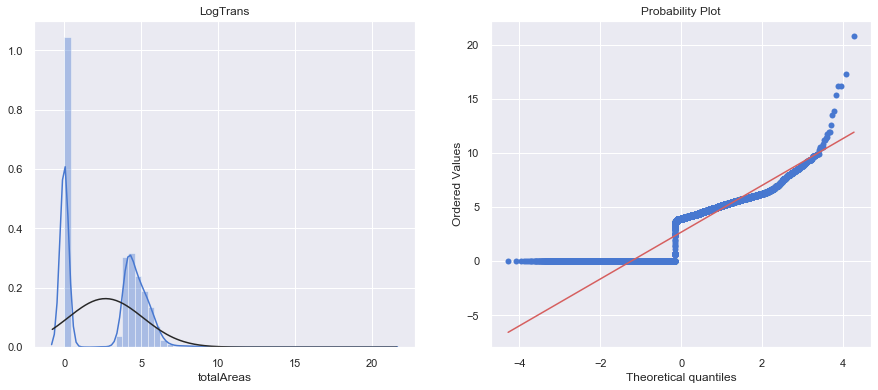

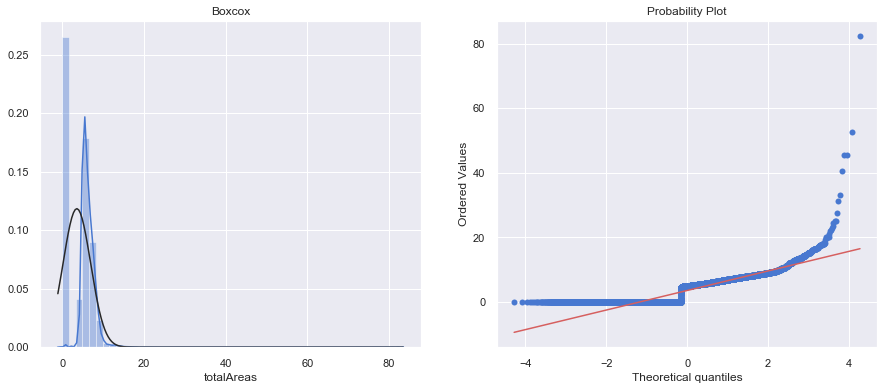

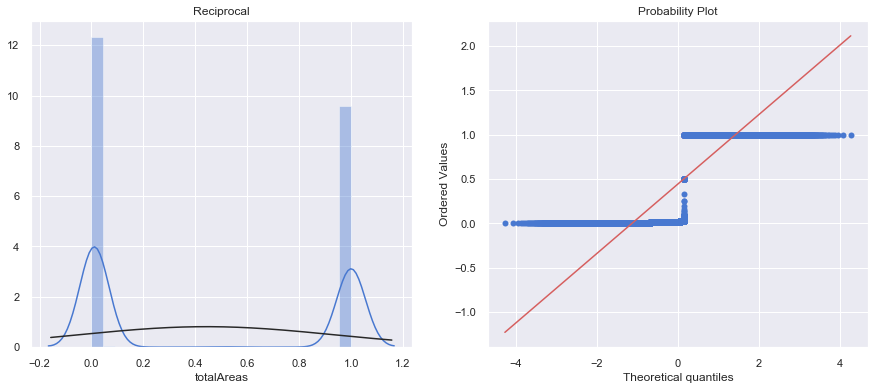

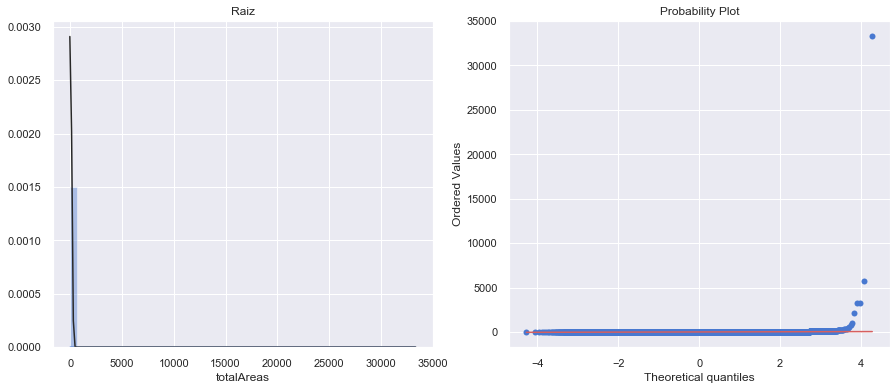

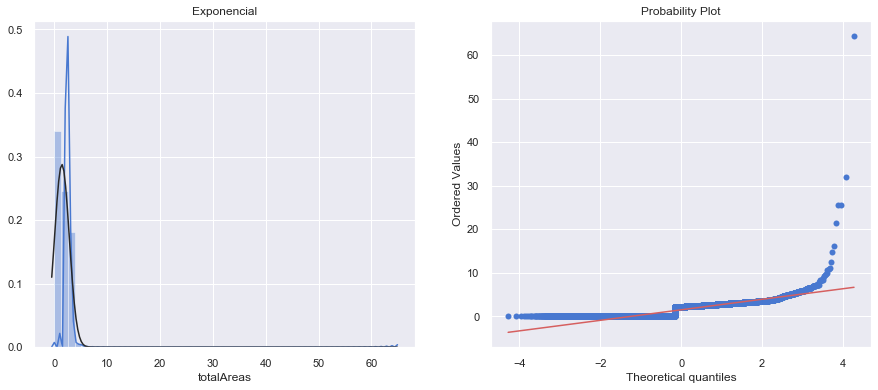

In [82]:
plotTransformations('totalAreas')

count    72,228.000000
mean        120.541064
std         596.682894
min           0.000000
25%          60.000000
50%          85.000000
76%         150.000000
99%         450.000000
max     129,000.000000
Name: usableAreas, dtype: float64

count   16,036.000000
mean       116.397418
std        565.367115
min          0.000000
25%         59.000000
50%         80.000000
76%        140.000000
99%        425.000000
max     70,600.000000
Name: usableAreas, dtype: float64

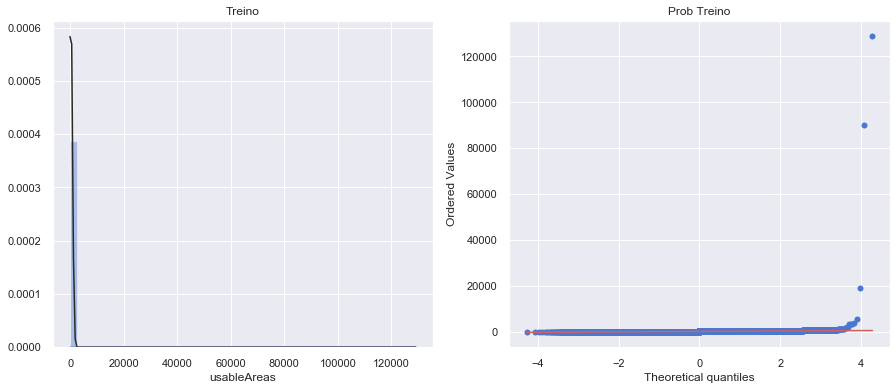

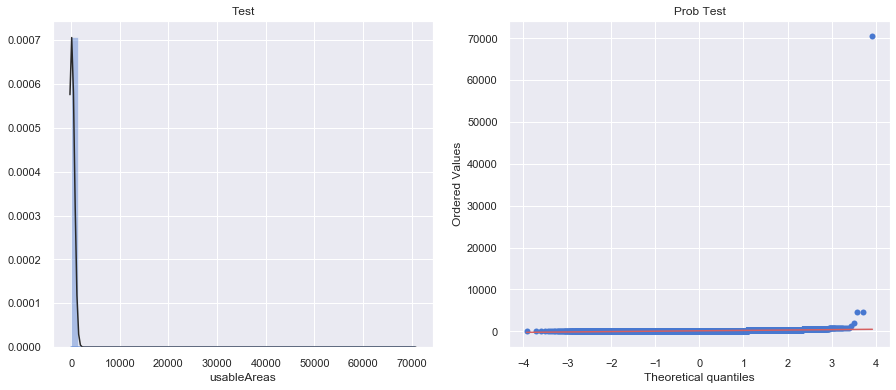

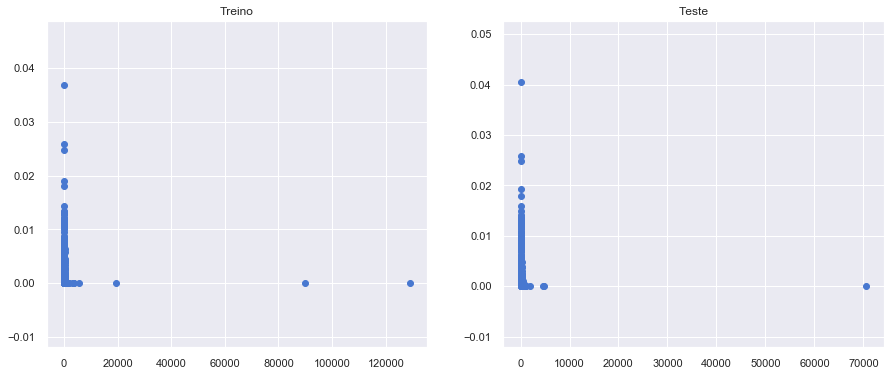

In [83]:
univariateAnalizeVar(train_nomiss, test_nomiss, 'usableAreas')

In [ ]:
train_nomiss.info()

In [ ]:
showRegressions('usableAreas')

In [ ]:
plotTransformations('usableAreas')

In [ ]:
for col in train_nomiss.columns:
    if '_na' in col:
        train_nomiss[col] = train_nomiss[col].astype('bool')
        test_nomiss[col] = test_nomiss[col].astype('bool')
        
display(train_nomiss.info())
display(test_nomiss.info())


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_nomiss, 
                                                    train_nomiss.price, test_size=0.3,
                                                    random_state=0)
#finalizando aqui a trabalhar

In [ ]:
#template a fazer
price_pipe = pipe([
    # add a binary variable to indicate missing information for the 2 variables below
    ('continuous_var_imputer', msi.AddNaNBinaryImputer(variables = [])),
     
    # replace NA by the median in the 3 variables below, they are numerical
    ('continuous_var_median_imputer', msi.MeanMedianImputer(imputation_method='median', variables = [])),
     
    # replace NA by adding the label "Missing" in categorical variables (transformer will skip those variables where there is no NA)
    ('categorical_imputer', msi.CategoricalVariableImputer(variables = categorical)),
     
    # disretise numerical variables using trees
    ('numerical_tree_discretiser', dsc.DecisionTreeDiscretiser(cv = 3, scoring='neg_mean_squared_error', variables = numerical, regression=True)),
     
    # remove rare labels in categorical and discrete variables
    ('rare_label_encoder', ce.RareLabelCategoricalEncoder(tol = 0.03, n_categories=1, variables = categorical+discrete)),
     
    # encode categorical variables using the target mean 
    ('categorical_encoder', ce.MeanCategoricalEncoder(variables = categorical+discrete))
     ])

In [ ]:
columns_x = [x for x in numericals if x != 'price']
X = train_nomiss[columns_x]
y = train_nomiss['price']
zap.featureImportanceLasso(X,y)
zap.plotMetricsImportance(X,y)

In [ ]:
def categorical_to_counts(df_train, df_test, arr_rows, target):
    # make a temporary copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()
    
    for col in arr_rows:
        # make the dictionary mapping label to counts
        X_frequency_map = df_train_temp[col].value_counts().to_dict()
        
        # remap the labels to their counts
        df_train_temp[col] = df_train_temp[col].map(X_frequency_map)
        df_test_temp[col] = df_test_temp[col].map(X_frequency_map)
    
    # drop the target
    df_train_temp.drop([target], axis=1, inplace=True)
    df_test_temp.drop([target], axis=1, inplace=True)
    
    return df_train_temp, df_test_temp

def categories_to_ordered(df_train, df_test, y, arr_rows, target):
    # make a temporary copy of the datasets 
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()
    df_train_temp[target] = y
    
    for col in arr_rows:
        # order the labels according to target mean
        #ordered_labels = df_train_temp.groupby([col])[target].median().sort_values().index
        ordered_labels = train_eda.groupby([col])[target].median().sort_values().index
        # create the dictionary to map the ordered labels to an ordinal number
        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
        # remap the categories  to these ordinal numbers
        df_train_temp[col] = df_train[col].map(ordinal_label)
        
        #df_test_temp[col].where(df_test_temp[col].isin(ordinal_label), 0, inplace=True)
        #df_test_temp[col+'new'] = df_test_temp[col].apply(lambda row: row if row in ordinal_label else 0 )
        df_test_temp[col] = df_test[col].map(ordinal_label, na_action='ignore')
        df_train_temp[col] = pd.to_numeric(df_train_temp[col])
        df_test_temp[col] = pd.to_numeric(df_test_temp[col].fillna(0))
    
    # remove the target
    df_train_temp.drop([target], axis=1, inplace=True)
    return df_train_temp, df_test_temp



def impute_na(df_train, df_test, variable):
    # add additional variable to indicate missingness
    df_train.loc[:, variable+'_NA'] = np.where(df_train[variable].isnull(), 1, 0)
    df_test.loc[:, variable+'_NA'] = np.where(df_test[variable].isnull(), 1, 0)
    
    # random sampling
    df_train.loc[:,variable+'_random'] = df_train[variable]
    df_test.loc[:,variable+'_random'] = df_test[variable]
    
    # extract the random sample to fill the na
    random_sample_train = df_train[variable].dropna().sample(df_train[variable].isnull().sum(), random_state=0).copy()
    random_sample_test = df_train[variable].dropna().sample(df_test[variable].isnull().sum(), random_state=0).copy()
    
    # pandas needs to have the same index in order to merge datasets
    random_sample_train.index = df_train[df_train[variable].isnull()].index
    random_sample_test.index = df_test[df_test[variable].isnull()].index
    
    df_train.loc[df_train[variable].isnull(), variable+'_random'] = random_sample_train
    df_test.loc[df_test[variable].isnull(), variable+'_random'] = random_sample_test
    del random_sample_train
    del random_sample_test


scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [ ]:

# recuperando aluguéis
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
al_x = aluguel_price[['bathrooms', 'bedrooms', 'parkingSpaces',
       'pricingInfos.monthlyCondoFee',  'price',
       'pricingInfos.yearlyIptu', 
       'suites', 'totalAreas', 'usableAreas', 'geohash', 'geohash_high']]
al_y = aluguel_price[['rentalTotalPrice']]
X, y = shuffle(al_x, al_y, random_state=13)

#X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

X_train, X_test = zap.categorical_to_counts(X_train,X_test, ['geohash','geohash_high'], 'rentalTotalPrice')
X_train, X_test = zap.impute_categorical_to_median(X_train,X_test,y_train, ['geohash','geohash_high'], 'rentalTotalPrice')
#median_Encode(newdf,'','geohash_high', 'rentalTotalPrice')
X_train = X_train.drop(labels=['geohash','geohash_high'], axis=1)
X_test = X_test.drop(labels=['geohash','geohash_high'], axis=1)
#newdf.shape

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)
print("R2: %.4f" % r2_score(y_test,clf.predict(X_test)))

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, al_x.iloc[:,1:].columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [ ]:
from pandas.plotting import scatter_matrix
median_cols = [x  for x in train_eda.loc[:,'bathrooms_median':].columns if '_media' in x]
#train_eda['parkingSpaces_median'].hist #(bins=15, figsize=(15, 6))#, layout=(2, 5))
#scatter_matrix(train_eda[median_cols], alpha=0.2, figsize=(15, 10), diagonal='kde')


In [ ]:
efs1 = EFS(RandomForestRegressor(n_jobs=4), 
           min_features=1,
           max_features=6, 
           scoring='r2',
           print_progress=True,
           cv=2)

efs1 = efs1.fit(np.array(X_train), y_train)